<a href="https://colab.research.google.com/github/ucheetah/exoplanet-viz-cluster/blob/main/NASA_exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NASA Exoplanet Data Analysis**

Notebook structure:

*   **Initial settings and style parameters**
*   Collecting and cleaning the Planetary Systems data
*   Missing value analysis and outlier handling
*   Planet radius - graphs
*   Distance from Earth - graphs

## **Initial settings and style parameters**

#### **Imports**

In [1]:
# Pandas and NumPy imports
import pandas as pd
import numpy as np

# Google Colab imports
from google.colab import drive
from google.colab import files
import requests

# Matplotli and Seaborn imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import seaborn.objects as so

# Scikit Learn imports
import sklearn as sk
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.mode.copy_on_write = True

#### **Save Figures Boolean**

In [2]:
save = True

#### **Drive upload**

In [3]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#### **Custom stylesheet import**


 I've imported a matplotlib stylesheet that I've personalized on the [dark_background](https://matplotlib.org/stable/gallery/style_sheets/dark_background.html) stylesheet. Sheet code can be found at [exoplanet_dark_background.mplstyle](https://github.com/ucheetah/exoplanet-viz-cluster/blob/85373ae0570f29821916d55ad1a52b39da345aed/exoplanet_dark_background.mplstyle).

In [4]:
matplotlib.style.use('/content/gdrive/MyDrive/exoplanet_dark_background.mplstyle')

Bad key figure.format in file /content/gdrive/MyDrive/exoplanet_dark_background.mplstyle, line 7 ('figure.format: svg')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


#### **Color palette**

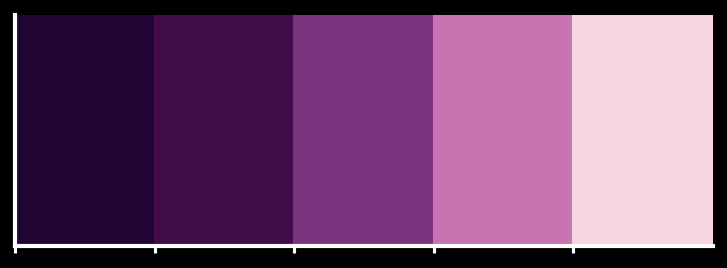

In [5]:
# Sequential color palette - array of purples
color_palette = ["#210535", "#430d4b", "#7b337d", "#c874b2", "#f5d5e0"]

# Display colors
fig, ax = plt.subplots(figsize=(6, 2), dpi = 150)

for idx, color in enumerate(color_palette):
    ax.add_patch(plt.Rectangle((idx, 0), 1, 1, color=color))

ax.set_xlim(0, len(color_palette))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(color_palette)))
ax.set_xticklabels([])
ax.set_yticks([])

plt.show()

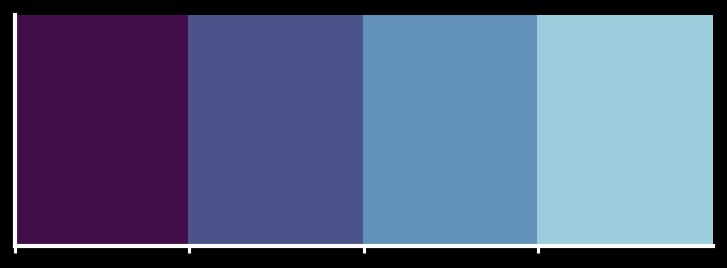

In [6]:
# Divergent color palette for kmeans

kmeans_palette = ["#430d4b", "#4a538a", "#6191b8", "#9ccddc"]


fig, ax = plt.subplots(figsize=(6, 2), dpi = 150)

for idx, color in enumerate(kmeans_palette):
    ax.add_patch(plt.Rectangle((idx, 0), 1, 1, color=color))

ax.set_xlim(0, len(kmeans_palette))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(kmeans_palette)))
ax.set_xticklabels([])
ax.set_yticks([])

plt.show()

## **Collecting and cleaning NASA exoplanet data**

We're grabbing data from [NASA exoplanets archive](https://exoplanetarchive.ipac.caltech.edu/index.html). The archive is a collaboration between the California Institute of Technology (Caltech) and NASA under the Exoplanet Exploration Program. We are drawing from the **Planetary Systems** dataset, which provides in depth data on every confirmed exoplanet known to astronomists to date. The Table contains one row per planet per reference and collects data such as its radius and mass, distance, stellar systems.

For many values such as mass and radius, the tables does include uncertainty columns, but I won't be concerned with them within the scope of this project. To be kept in mind that values can have confidence intervals of sizes of hundreds of units.


#### **Choosing varables of interest**

From the [parameter table documentation](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html) for this dataset I chose a small set of values from the dataset that are likely to be of biggest immediate interest:

*   `pl_name`: Planet name
*   `sy_dist`: Distance [pc] (Distance to the planetary system in units of parsecs)
*   `pl_rade`: Planet Radius [Earth Radius]
*   `pl_masse`: Planet Mass [Earth Mass]


#### **Querying the data**

To query this data we generate the industry standard **Table Access Protocol (TAP)** which uses **AQDL (Astronomical Query Data Language)** - akin to SQL for astronomical databases - to write queries.

*   Use Python's `requests` package to access NASA data using TAP protocol. I've written a short SQL (technically AQDL) queries which paired with `requests` grabs these columns:

```
          SELECT pl_name, sy_dist, pl_rade,pl_masse
          FROM ps
```
To fit it into a [TAP protocol](https://exoplanetarchive.ipac.caltech.edu/docs/TAP/usingTAP.html) we simply need to make a few adjustments such as remove additional spacing, add `+` between the major SQL statements. Full procedure:

*   Write data as a CSV into MyDrive.
*   Call CSV into notebook.

##### **SQL (AQDL) Query**

In [105]:
request_csv = requests.get("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,sy_dist,pl_rade,pl_masse+from+ps&format=csv")

with open('/content/gdrive/MyDrive/exoplanet_data.csv', 'w') as f:
    f.write(request_csv.text)

Call CSV into notebook

In [166]:
exoplanet_data_raw = pd.read_csv('/content/gdrive/MyDrive/exoplanet_data.csv')

Off the bat we will just adjust column names

In [232]:
exoplanet_data_raw = exoplanet_data_raw.rename(
    columns = {
      "pl_name": "planet_name",
      "sy_dist": "distance_pc",
      "pl_rade": "planet_radius",
      "pl_masse": "planet_mass"
      })

#### **Exploratory data analysis**

Now that we've obtained our data can perform some preliminary EDA on it:

In [237]:
exoplanet_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35968 entries, 0 to 35967
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   planet_name     35968 non-null  object 
 1   distance_pc     35136 non-null  float64
 2   planet_radius   24453 non-null  float64
 3   planet_mass     3709 non-null   float64
 4   missing_radius  35968 non-null  bool   
dtypes: bool(1), float64(3), object(1)
memory usage: 1.1+ MB


In [236]:
exoplanet_data_raw.head()

planet_name  distance_pc  planet_radius  planet_mass  missing_radius
0  OGLE-TR-10 b    1344.9700         14.011      197.046           False
1  BD-08 2823 b      41.3342            NaN          NaN            True
2  BD-08 2823 c      41.3342            NaN          NaN            True
3     HR 8799 c      41.2441         13.000     3000.000           False
4   HD 104985 b     100.5760            NaN          NaN            True

In [238]:
exoplanet_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35968 entries, 0 to 35967
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   planet_name     35968 non-null  object 
 1   distance_pc     35136 non-null  float64
 2   planet_radius   24453 non-null  float64
 3   planet_mass     3709 non-null   float64
 4   missing_radius  35968 non-null  bool   
dtypes: bool(1), float64(3), object(1)
memory usage: 1.1+ MB


#### **Column renaming and cleaning**

We can make a few adjustments to the data. We can replace columns and delete duplicate entries:

In [227]:
exoplanet_data = exoplanet_data_raw.dropna()
exoplanet_data = exoplanet_data.drop_duplicates(subset=['planet_name']).reset_index(drop=True)

Using `.describe()` we  note that there appears to be significant discrepancies in `count`; missing values could provide more context.

In [239]:
exo_describe = exoplanet_data.describe()
exo_describe = exo_describe.T
exo_describe = exo_describe.round(0).astype(int)
exo_describe

count  mean  std  min  25%  50%  75%   max
distance_pc     1307   395  394    7  123  283  524  4483
planet_radius   1307     8    6    0    2    9   13    77
planet_mass     1307   383  914    0   11   89  327  9535

We notice now that our table has been significantly reduced in size (from 35k to 5k) without duplicates.

In [240]:
exoplanets

planet_name  distance_pc  planet_radius  planet_mass  missing_radius
0     OGLE-TR-10 b    1344.9700         14.011    197.04600           False
1        HR 8799 c      41.2441         13.000   3000.00000           False
2        WASP-43 b      86.7467         11.276    635.02434           False
3        WASP-47 b     264.7800         12.770    341.00000           False
4        WASP-47 d     264.7800          3.630     15.20000           False
...            ...          ...            ...          ...             ...
1302       K2-77 b     141.7310          2.300    603.87700           False
1303    KOI-1833 d     290.3240          2.580     11.02000           False
1304    KOI-3503 b     887.0640          1.190      9.20000           False
1305    KOI-3503 c     887.0640          1.210     10.36000           False
1306     TOI-532 b     135.0470          5.820     61.50000           False

[1307 rows x 5 columns]

### **Outlier handling**

We can take a look at outliers.

#### **Radius outliers**

Looking at the percentiles we notice that only above the 90th percentile does the radius seem to shoot upwards.

In [15]:
exoplanets['planet_radius'].describe(percentiles = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

count    483.000000
mean       9.273747
std        6.775758
min        0.696000
0%         0.696000
10%        1.700800
20%        2.452000
30%        3.108000
40%        6.360800
50%       10.705000
60%       11.990800
70%       13.101200
80%       14.423800
90%       16.418800
100%      77.342000
max       77.342000
Name: planet_radius, dtype: float64

As we can see by tracking the largest radii (>50x Earth radius) we see five major values, some of which seem excessively large.

In [99]:
exoplanets[(exoplanets['planet_radius'] > 50)].loc[:,:].sort_values(by="planet_radius", ascending = False)

planet_name  distance_pc  planet_radius  planet_mass
543  HD 100546 b      109.677         77.342   2701.54146

This is suspiciously large but quickly referencing NASA's pages on these exoplanets we determine it is accurate: **HD 100546** - 77.34x Earth radius - [HD 100546](https://science.nasa.gov/exoplanet-catalog/hd-100546-b/). Looking at the table once more our results are more sensible. HD 100546 b	is by many sources listed as the exoplanet with the biggest known radius.

In [100]:
exoplanets.sort_values(by="planet_radius", ascending = False)

planet_name  distance_pc  planet_radius  planet_mass
543    HD 100546 b     109.6770         77.342   2701.54146
155     HAT-P-35 b     506.9650         39.792   2390.08160
1131      GQ Lup b     151.1690         33.600   6356.00000
1245      PDS 70 b     113.0640         30.488    953.49000
1273      DH Tau b     134.8460         30.264   3496.13000
...            ...          ...            ...          ...
1095   KOI-4777.01     172.2450          0.510     99.20000
1017  Kepler-444 d      36.4396          0.500      0.20000
1038  Kepler-444 e      36.4396          0.500      0.10000
726   Kepler-102 b     107.7960          0.460      1.10000
694    Kepler-37 b      63.9207          0.320     10.00000

[1307 rows x 4 columns]

We will deliberately exclude the maximum planet radius because it is so large it has the potential to affect results.

In [101]:
exoplanets = exoplanets[exoplanets['planet_radius'] != exoplanets['planet_radius'].max()]

#### **Mass outliers**

Does not appear to be any significant outliers.

HR 2562 b is the largest recorded exoplanet with a whooping


In [102]:
exoplanets.sort_values(by="planet_mass", ascending = False).head(10)

planet_name  distance_pc  planet_radius  planet_mass
567     HR 2562 b      34.0071         12.442   9534.90000
734   HD 206893 b      40.7583         14.011   8899.19540
380      KELT-1 b     268.4300         12.442   8654.15000
504   KOI-2513.01    1369.8700          2.802   7310.05336
583    TOI-1994 b     515.6030         13.675   7024.00779
745      HN Peg b      18.1186         11.777   6991.57000
985     CoRoT-3 b     768.7710         11.624   6979.54680
1144  Kepler-39 b    1057.4100         13.900   6388.10000
1131     GQ Lup b     151.1690         33.600   6356.00000
786     bet Pic b      19.7442         16.800   6356.00000

#### **Distance outliers**

In [241]:
exoplanets = exoplanets[exoplanets['distance_pc'] != exoplanets['distance_pc'].max()]

In [242]:
exoplanets.sort_values(by="distance_pc", ascending = False).head(10)

planet_name  distance_pc  planet_radius  planet_mass  missing_radius
1277  OGLE-TR-182 b      2501.75         16.477     336.8998           False
1281        WTS-1 b      2346.01         16.700    1274.4400           False
1005    Kepler-40 b      2305.01         16.141     686.5128           False
1194   Kepler-328 c      2213.19          5.400      39.4000           False
1231   Kepler-328 b      2213.19          2.300      28.5000           False
1127  OGLE-TR-132 b      2012.62         13.227     362.3262           False
1057     CoRoT-31 b      2005.76         16.365     266.9772           False
1140   Kepler-433 b      1878.31         16.253     893.1023           False
1210   Kepler-223 c      1859.71          2.600      12.4000           False
1184   Kepler-223 d      1859.71          5.240       8.0000           False

In [243]:
exoplanets

planet_name  distance_pc  planet_radius  planet_mass  missing_radius
0     OGLE-TR-10 b    1344.9700         14.011    197.04600           False
1        HR 8799 c      41.2441         13.000   3000.00000           False
2        WASP-43 b      86.7467         11.276    635.02434           False
3        WASP-47 b     264.7800         12.770    341.00000           False
4        WASP-47 d     264.7800          3.630     15.20000           False
...            ...          ...            ...          ...             ...
1302       K2-77 b     141.7310          2.300    603.87700           False
1303    KOI-1833 d     290.3240          2.580     11.02000           False
1304    KOI-3503 b     887.0640          1.190      9.20000           False
1305    KOI-3503 c     887.0640          1.210     10.36000           False
1306     TOI-532 b     135.0470          5.820     61.50000           False

[1306 rows x 5 columns]

## **Clustering**

### **ML Pre-processing**

Select for radius and mass columns, perform imputation and standardization.

In [23]:
# Standardization - We are using a traditional standardization making the mean 0 and std 1
scaler = StandardScaler()
exoplanet_scaled =scaler.fit_transform(exoplanets[['planet_radius', 'planet_mass']])

In [24]:
print("First few rows of scaled data:")
print(exoplanet_scaled[:5])

First few rows of scaled data:
[[ 0.81055947 -0.24390198]
 [ 0.64282536  2.37282638]
 [ 0.60466627 -0.10951215]
 [-0.91174299 -0.4136663 ]
 [-1.2105453  -0.40731809]]


### **Silhouette score analysis**

Silhouette scores allow yo uto determine how effective the kmeans algorithm is at grouping similar data points together. In a silhouette analysis we compare different numbers of categorizations and choose the highest silhouette score.

Silhouette scores range from -1 to 1. The higher the score, the better the clustering.

Clearly kmeans on 3 or 4 clusters appear to be most effective.

#### **Graph - Silhouette scores**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

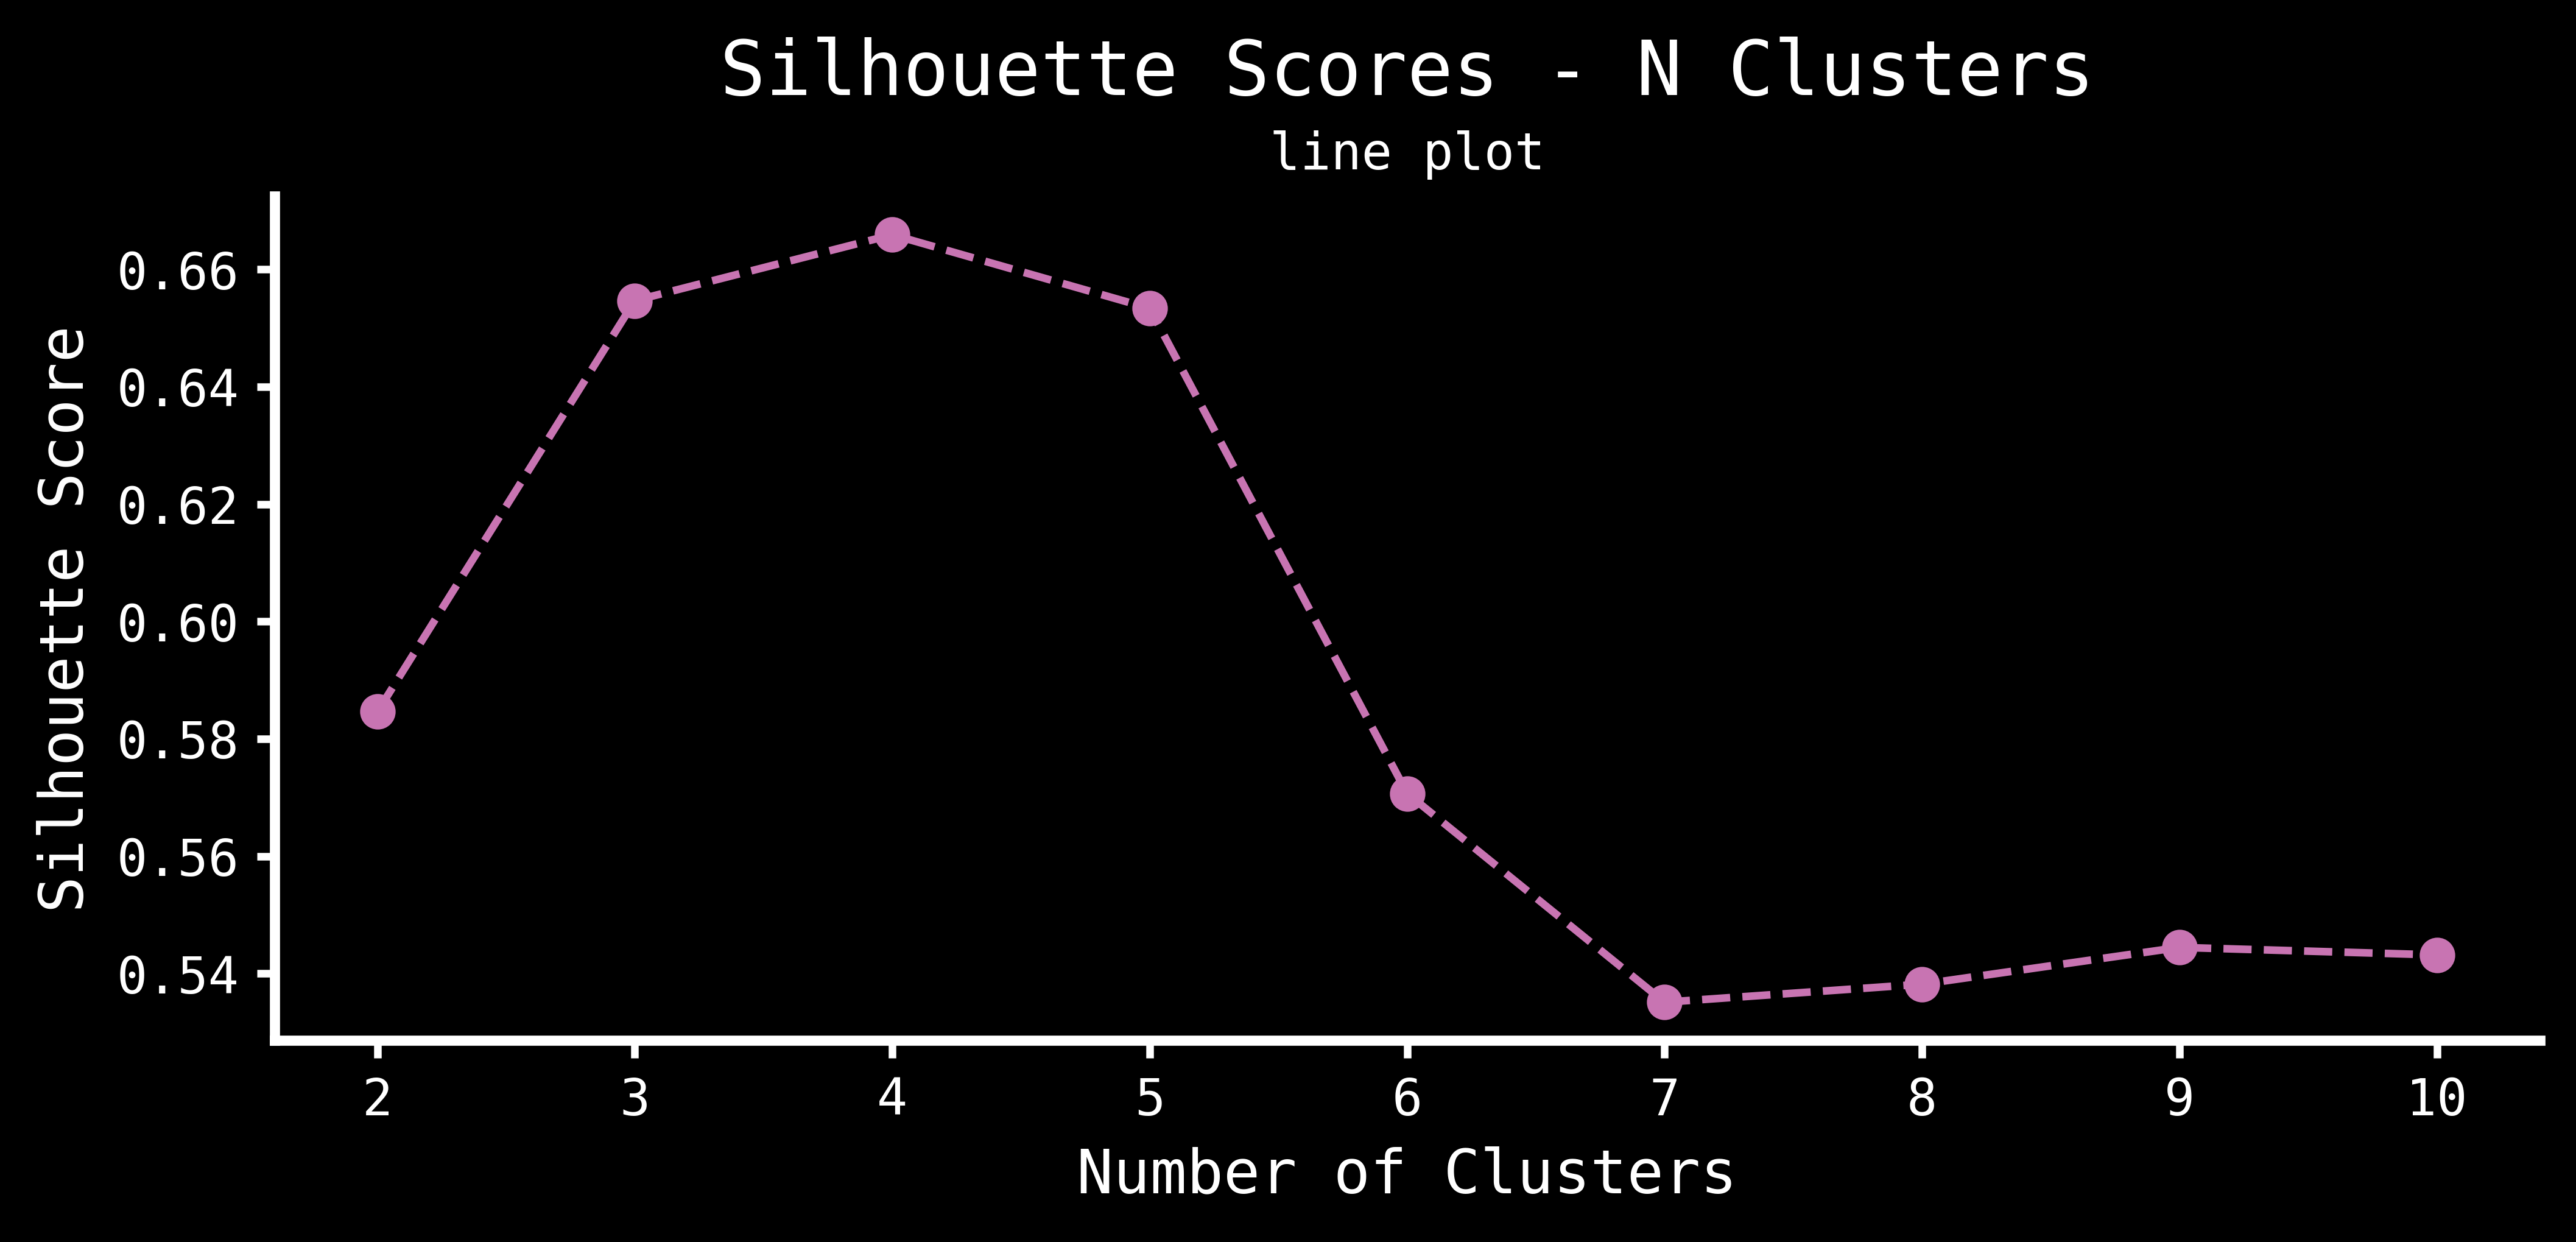

In [25]:
# Silhouette score generation
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=42)
    cluster_labels = kmeans.fit_predict(exoplanet_scaled)
    silhouette_avg = silhouette_score(exoplanet_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 3))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color ='#c874b2')
plt.title('Silhouette Scores - N Clusters', pad = 20)
plt.text(0.5, 1.02, "line plot", ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

if save == True:
  plt.savefig("2024-05-24-silhoutette.png", bbox_inches = 'tight')
  files.download("2024-05-24-silhoutette.png")
else:
  plt.show()

### **Apply Kmeans**

In [26]:
kmeans = KMeans(n_clusters = 4, n_init = 40)
kmeans.fit(exoplanet_scaled)
clusters = kmeans.predict(exoplanet_scaled)

In [27]:
centroids_scaled = kmeans.cluster_centers_
print("Centroids in scaled data:")
print(centroids_scaled)

centroids_original_scale = scaler.inverse_transform(centroids_scaled)
print("Centroids in original scale:")
print(centroids_original_scale)

Centroids in scaled data:
[[-1.01216303 -0.38375625]
 [ 0.71142878  1.93506867]
 [ 1.37409741  5.84247163]
 [ 0.76938264 -0.07745832]]
Centroids in original scale:
[[3.02472857e+00 4.72386680e+01]
 [1.34135000e+01 2.53108823e+03]
 [1.74076667e+01 6.71657074e+03]
 [1.37628109e+01 3.75335013e+02]]


In [28]:
exoplanets_clustered = exoplanets

In [29]:
exoplanets_clustered.loc[:,'cluster'] = clusters+1
exoplanets_clustered

planet_name  distance_pc  planet_radius  planet_mass  cluster
0         OGLE-TR-10 b    1344.9700         14.011    197.04600        4
3            HR 8799 c      41.2441         13.000   3000.00000        2
22           WASP-47 b     264.7800         12.770    341.00000        4
24           WASP-47 d     264.7800          3.630     15.20000        1
25           WASP-47 e     264.7800          1.829     22.00000        1
...                ...          ...            ...          ...      ...
5602  EPIC 249893012 d     321.2960          3.940     10.18000        1
5604         NGTS-15 b     786.4850         12.330    238.68913        4
5605         NGTS-17 b    1040.2800         13.899    242.82090        4
5606         NGTS-16 b     898.1680         14.572    211.99155        4
5628         TOI-532 b     135.0470          5.820     61.50000        1

[481 rows x 5 columns]

## **Graphs**

In [140]:
save = False

#### **Graph A - Missing values table**

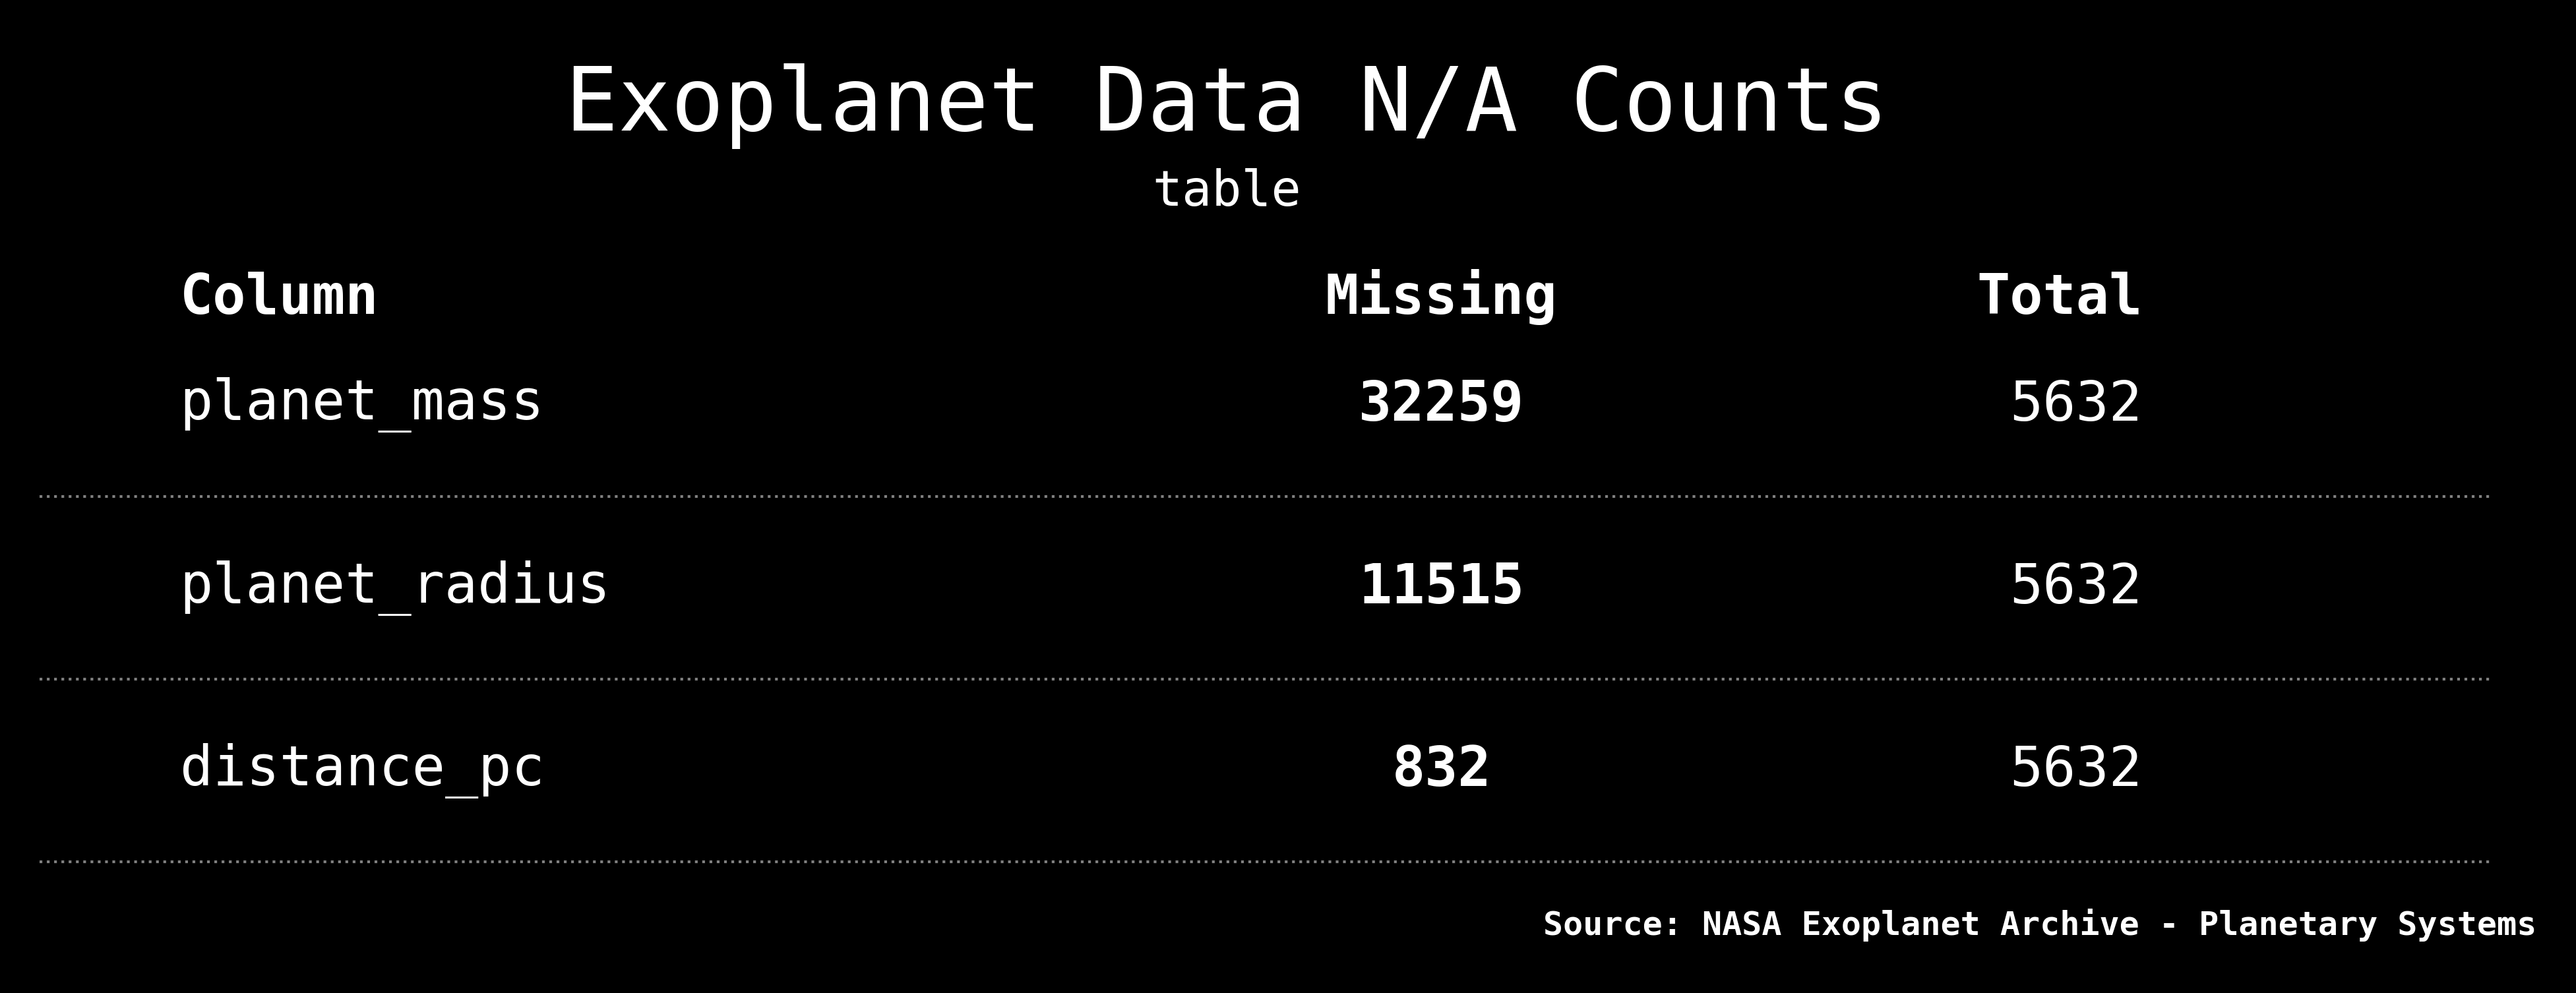

In [226]:
nullsums = exoplanet_data_raw.isnull().sum()
nullsums = nullsums[nullsums > 0].sort_values(ascending=True)
data = [{'attribute': index, 'nulls': nullsums[index], 'count': 5632} for index in nullsums.index]

fig, ax = plt.subplots(figsize=(8,3))

fig.suptitle('Exoplanet Data N/A Counts', x= 0.5, y= 0.86, fontsize=16)
fig.text(0.6, 0.12, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=6, fontweight='bold')
fig.text(0.5, 0.74, "table", ha='center', fontsize=9)

# Coordinate system based on row and column numbers
rows = 3
cols = 3
ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + .5)

for row in range(rows):
    d = data[row]
    ax.text(x=.2, y=row, s=d['attribute'], va='center', ha='left')
    ax.text(x=2, y=row, s=d['nulls'], va='center', ha='center', weight='bold')
    ax.text(x=3, y=row, s=d['count'], va='center', ha='right')

ax.text(.2, 2.5, 'Column', weight='bold', ha='left')
ax.text(2, 2.5, 'Missing', weight='bold', ha='center')
ax.text(3, 2.5, 'Total', weight='bold', ha='right')
ax.axis('off')

for row in range(rows):
    ax.plot(
    	[0, cols + 1],
    	[row -.5, row - .5],
    	ls=':',
    	lw='.5',
    	c='grey'
    )

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-1.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-1.png")
else:
  plt.show()

#### **Graph B: Known vs. unknown radius (histogram)**

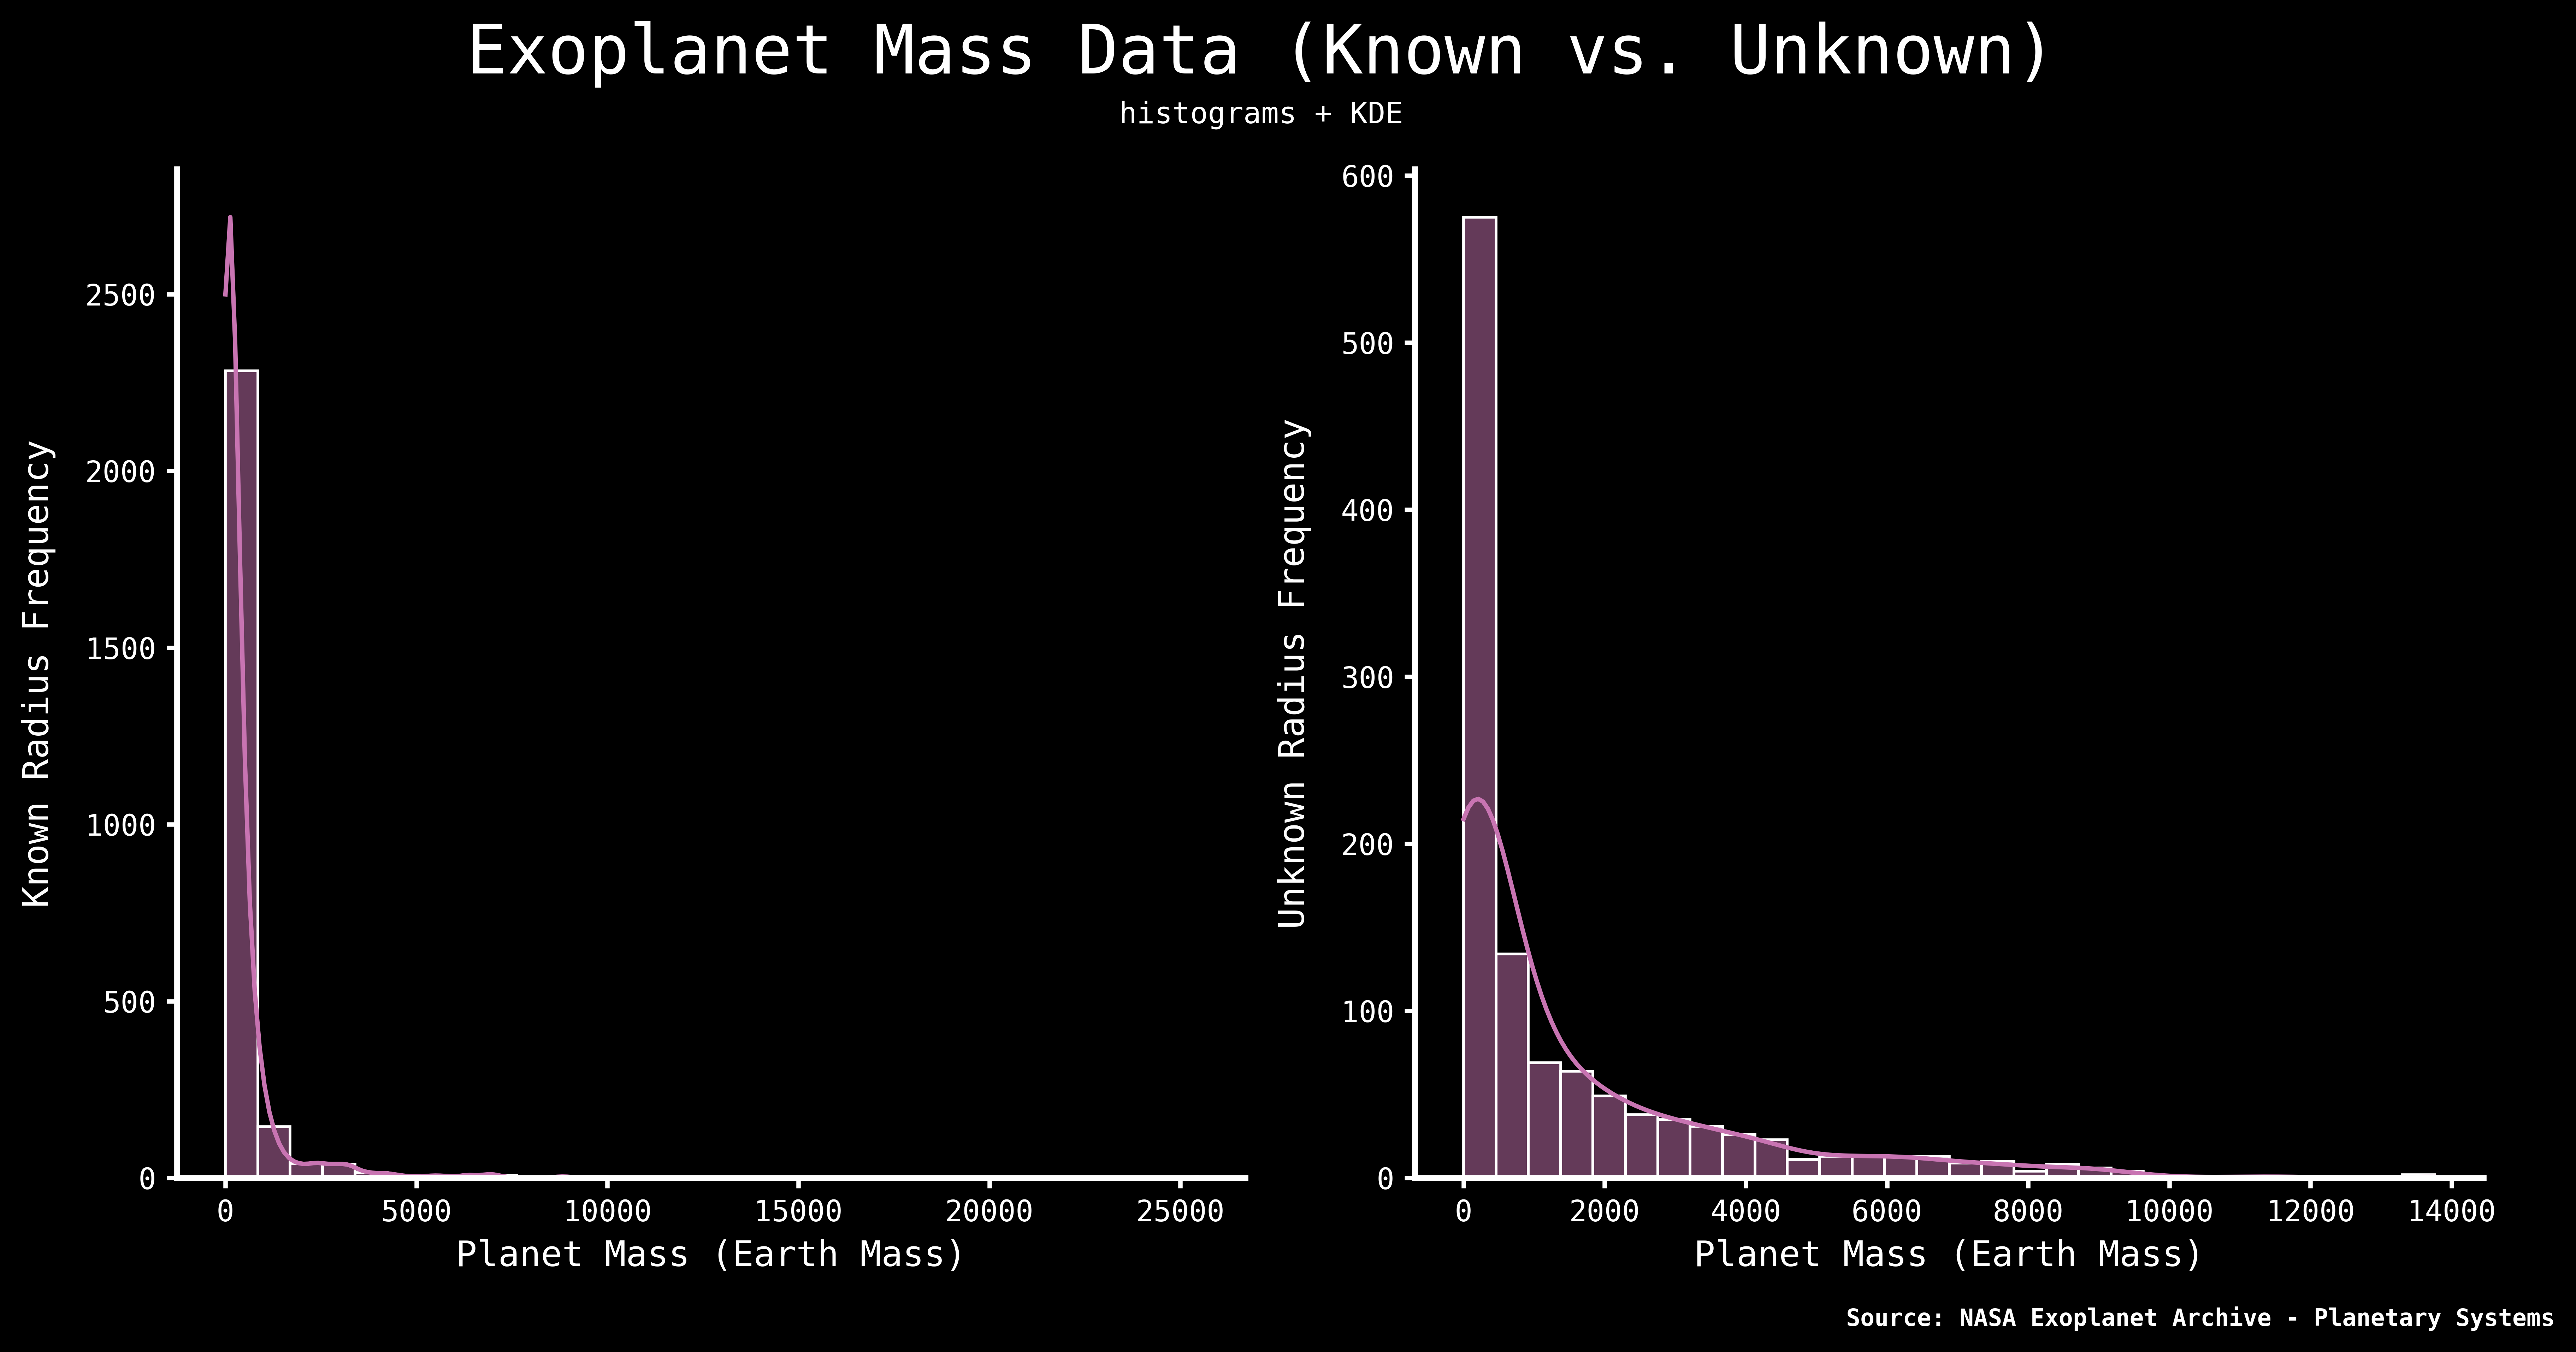

In [177]:
exoplanet_data_raw['missing_radius'] = exoplanet_data_raw['planet_radius'].isnull()
known_radius_mass = exoplanet_data_raw[exoplanet_data_raw['missing_radius'] == False]['planet_mass']
unknown_radius_mass = exoplanet_data_raw[exoplanet_data_raw['missing_radius'] == True]['planet_mass']

fig = plt.figure(figsize=(12, 6))

fig.suptitle("Exoplanet Mass Data (Known vs. Unknown)",  y=1.01, fontsize = 23)
fig.text(0.5, 0.93, "histograms + KDE", ha='center', fontsize=10)
fig.text(0.73, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')

# Histogram - Known radius
plt.subplot(1, 2, 1)
sns.histplot(known_radius_mass, bins=30, color="#c874b2", kde=True, orientation ='horizontal')
plt.xlabel('Planet Mass (Earth Mass)')
plt.ylabel('Known Radius Frequency', labelpad = 10)

# Histogram - Unknown radius
plt.subplot(1, 2, 2)
sns.histplot(unknown_radius_mass, bins=30, color="#c874b2", orientation ='horizontal', kde=True)
plt.xlabel('Planet Mass (Earth Mass)')
plt.ylabel('Unknown Radius Frequency', labelpad = 10)

plt.tight_layout()

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-2.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-2.png")
else:
  plt.show()

#### **Graph C - Description dataset**

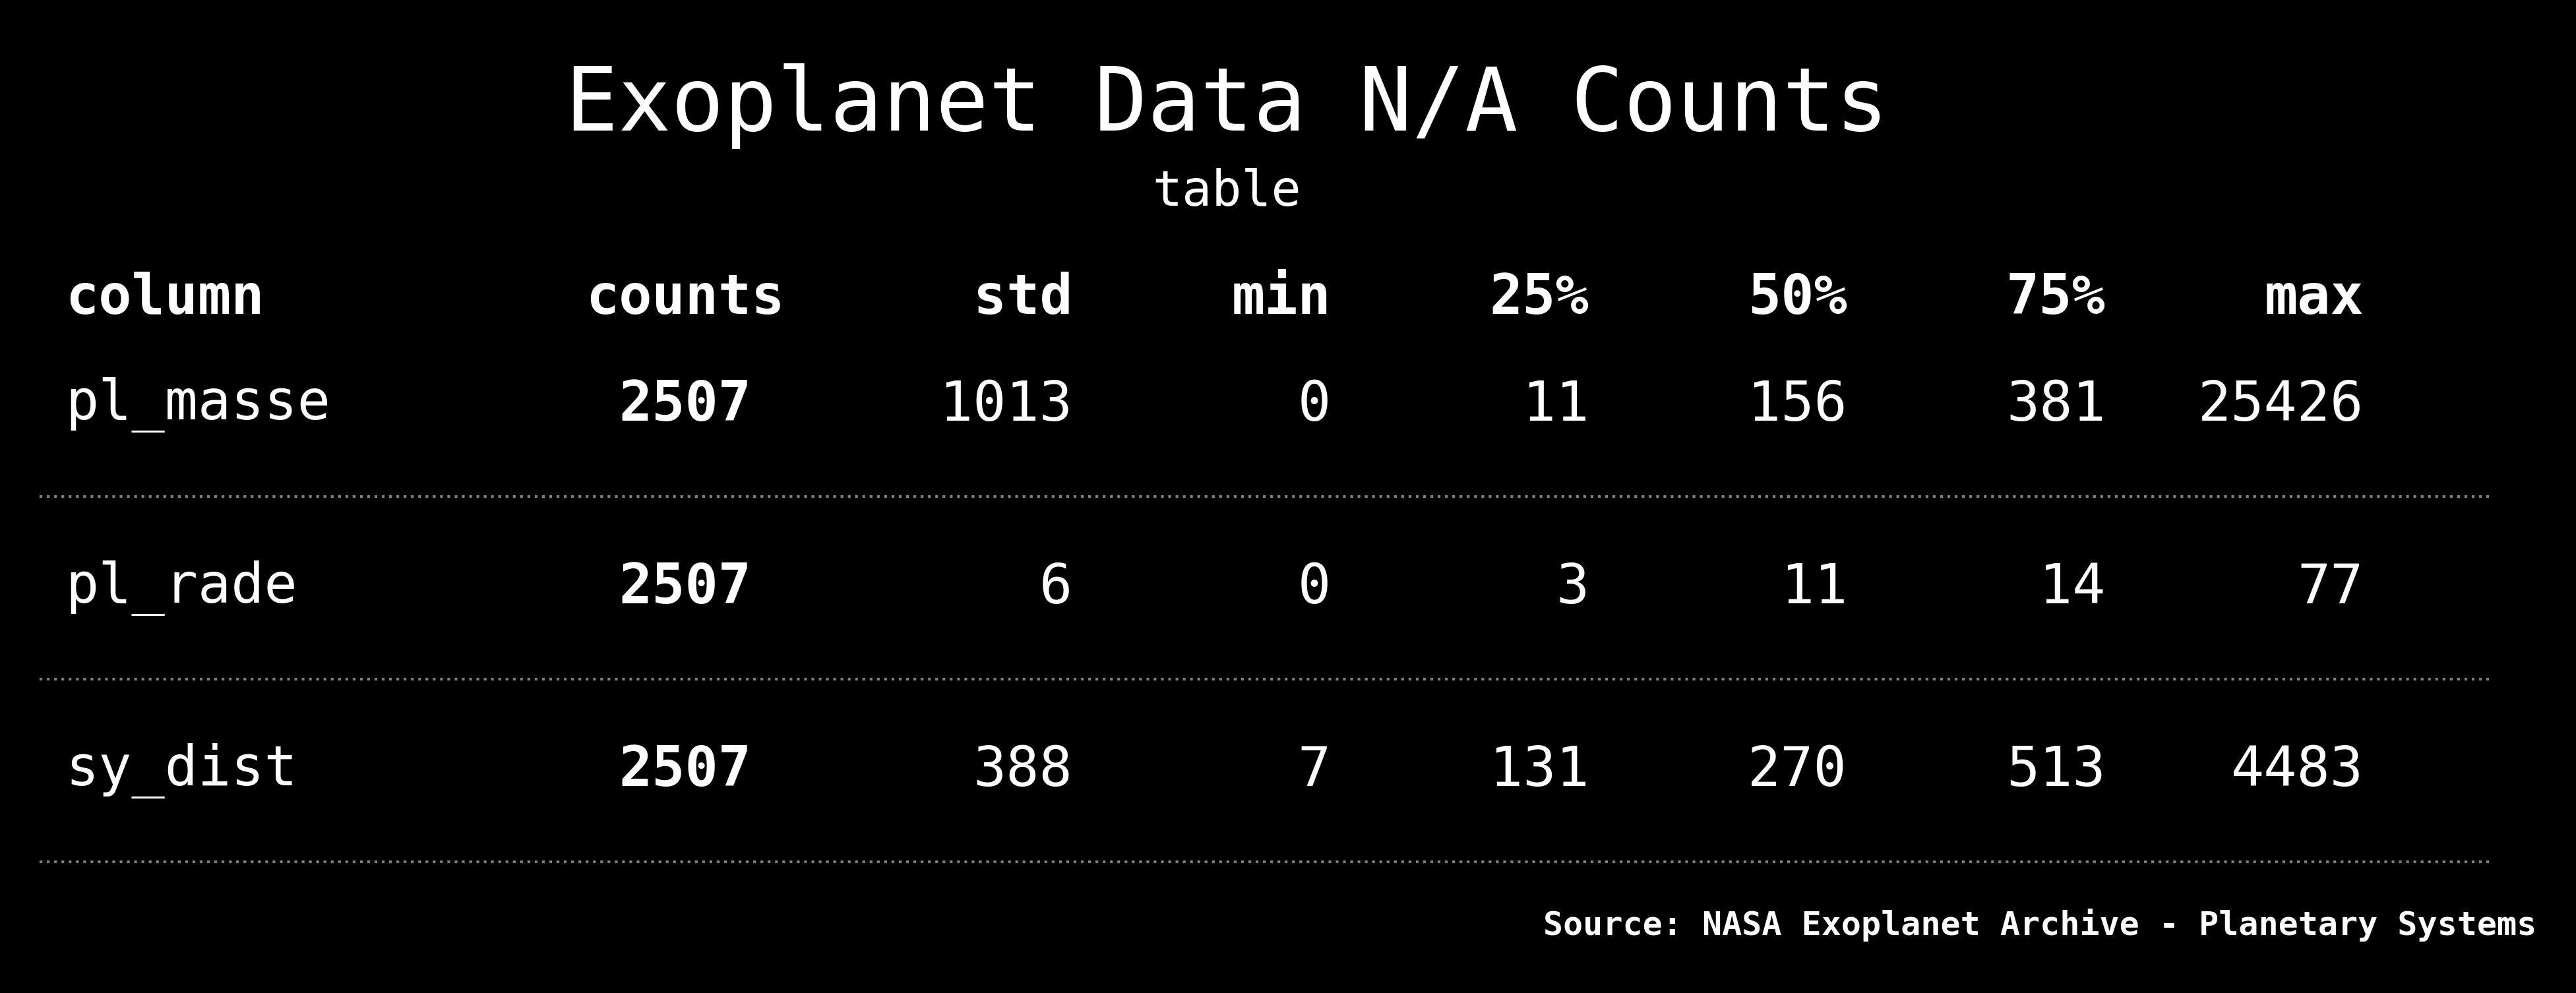

In [224]:
data = [{'attribute': index,
         'counts': exo_describe.loc[index,'count'],
         'std': exo_describe.loc[index,'std'],
         'min': exo_describe.loc[index,'min'],
         '25%': exo_describe.loc[index,'25%'],
         '50%': exo_describe.loc[index,'50%'],
         '75%': exo_describe.loc[index,'75%'],
         'max': exo_describe.loc[index,'max']} for index in exo_describe.index]

fig, ax = plt.subplots(figsize=(8,3))

fig.suptitle('Exoplanet Data N/A Counts', x= 0.5, y= 0.86, fontsize=16)
fig.text(0.6, 0.12, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=6, fontweight='bold')
fig.text(0.5, 0.74, "table", ha='center', fontsize=9)

# Coordinate space based on row and column numbers

rows = 3
cols = 9

# Create a coordinate system based on the number of rows and columns. Adding a bit of padding on bottom (-1), top (1), right (0.5)

ax.set_ylim(-1, rows + 1)
ax.set_xlim(0, cols + .5)

for row in range(rows):
    d = data[row]

    ax.text(x=0.1, y=row, s=d['attribute'], va='center', ha='left')
    ax.text(x=2.5, y=row, s=d['counts'], va='center', ha='center', weight='bold')
    ax.text(x=4, y=row, s=d['std'], va='center', ha='right')
    ax.text(x=5, y=row, s=d['min'], va='center', ha='right')
    ax.text(x=6, y=row, s=d['25%'], va='center', ha='right')
    ax.text(x=7, y=row, s=d['50%'], va='center', ha='right')
    ax.text(x=8, y=row, s=d['75%'], va='center', ha='right')
    ax.text(x=9, y=row, s=d['max'], va='center', ha='right')


ax.text(0.1, 2.5, 'column', weight='bold', ha='left')
ax.text(2.5, 2.5, 'counts', weight='bold', ha='center')
ax.text(4, 2.5, 'std', weight='bold', ha='right')
ax.text(5, 2.5, 'min', weight='bold', ha='right')
ax.text(6, 2.5, '25%', weight='bold', ha='right')
ax.text(7, 2.5, '50%', weight='bold', ha='right')
ax.text(8, 2.5, '75%', weight='bold', ha='right')
ax.text(9, 2.5, 'max', weight='bold', ha='right')

ax.axis('off')
for row in range(rows):
    ax.plot(
    	[0, cols + 1],
    	[row -.5, row - .5],
    	ls=':',
    	lw='.5',
    	c='grey'
    )

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-1.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-1.png")
else:
  plt.show()

#### **Graph D: Distance from Earth (histogram)**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

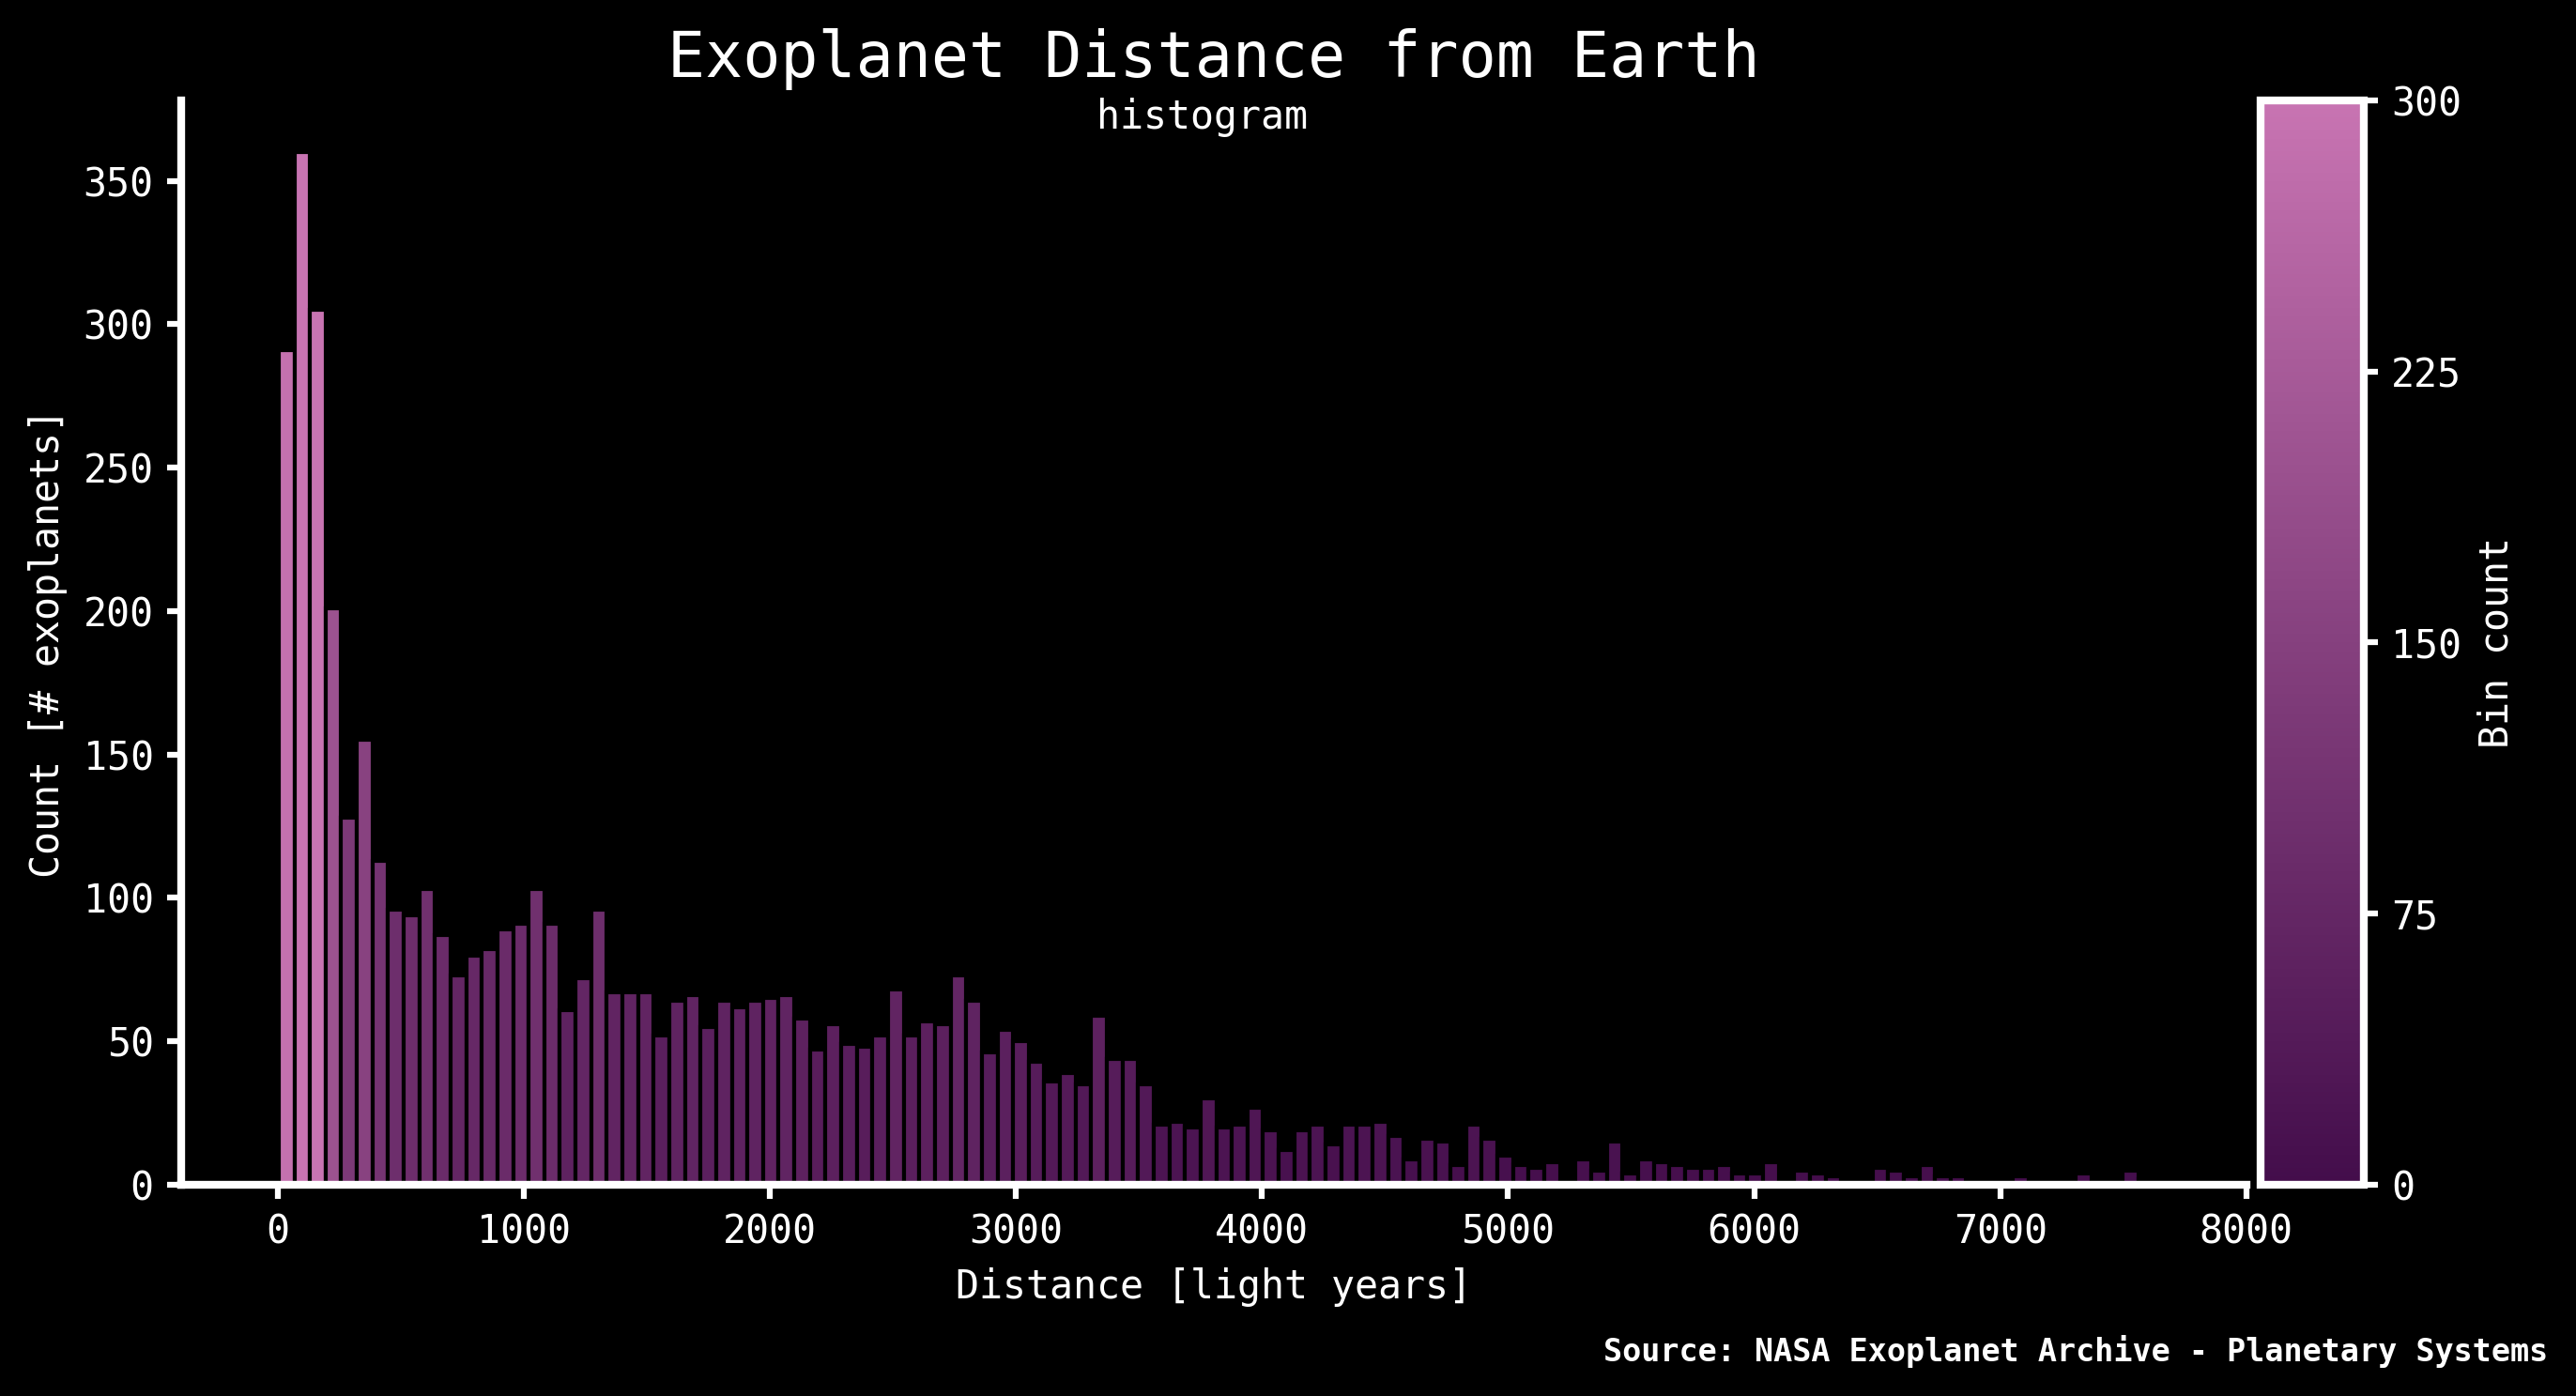

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))
fig.dpi = 300

# Histogram computation
filtered_distances = exoplanets[exoplanets['Distance [pc]'] * 3.26 < 8000]
counts, bins, patches = ax.hist(filtered_distances['Distance [pc]'] * 3.26, bins=125, edgecolor='black')
cmap = LinearSegmentedColormap.from_list("my_gradient", ["#430d4b", "#C874B2"])
norm = plt.Normalize(counts.min(), 300)

# Axis settings
ax.set_xlabel('Distance [light years]', fontsize=10)
ax.set_xlim(right=8000)
ax.set_ylabel('Count [# exoplanets]', fontsize=10)
ax.set_aspect('auto')
ax.grid(False)
ax.set_title('Exoplanet Distance from Earth', fontsize=16)
fig.text(0.45, 0.86, "histogram", fontsize=10)
fig.text(0.63, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')

# Color settings for the histogram
for count, bin, patch in zip(counts, bins, patches):
    color = cmap(norm(count))
    patch.set_facecolor(color)

# Create an Axes for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Colorbar and ticks
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = [0, 75, 150, 225, 300]
cbar = plt.colorbar(sm, cax=cax, ticks=ticks)
cbar.set_label('Bin count', fontsize=10)

# Spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-3.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-3.png")
else:
  plt.show()

#### **Graph E: Distance from Earth (CDF)**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

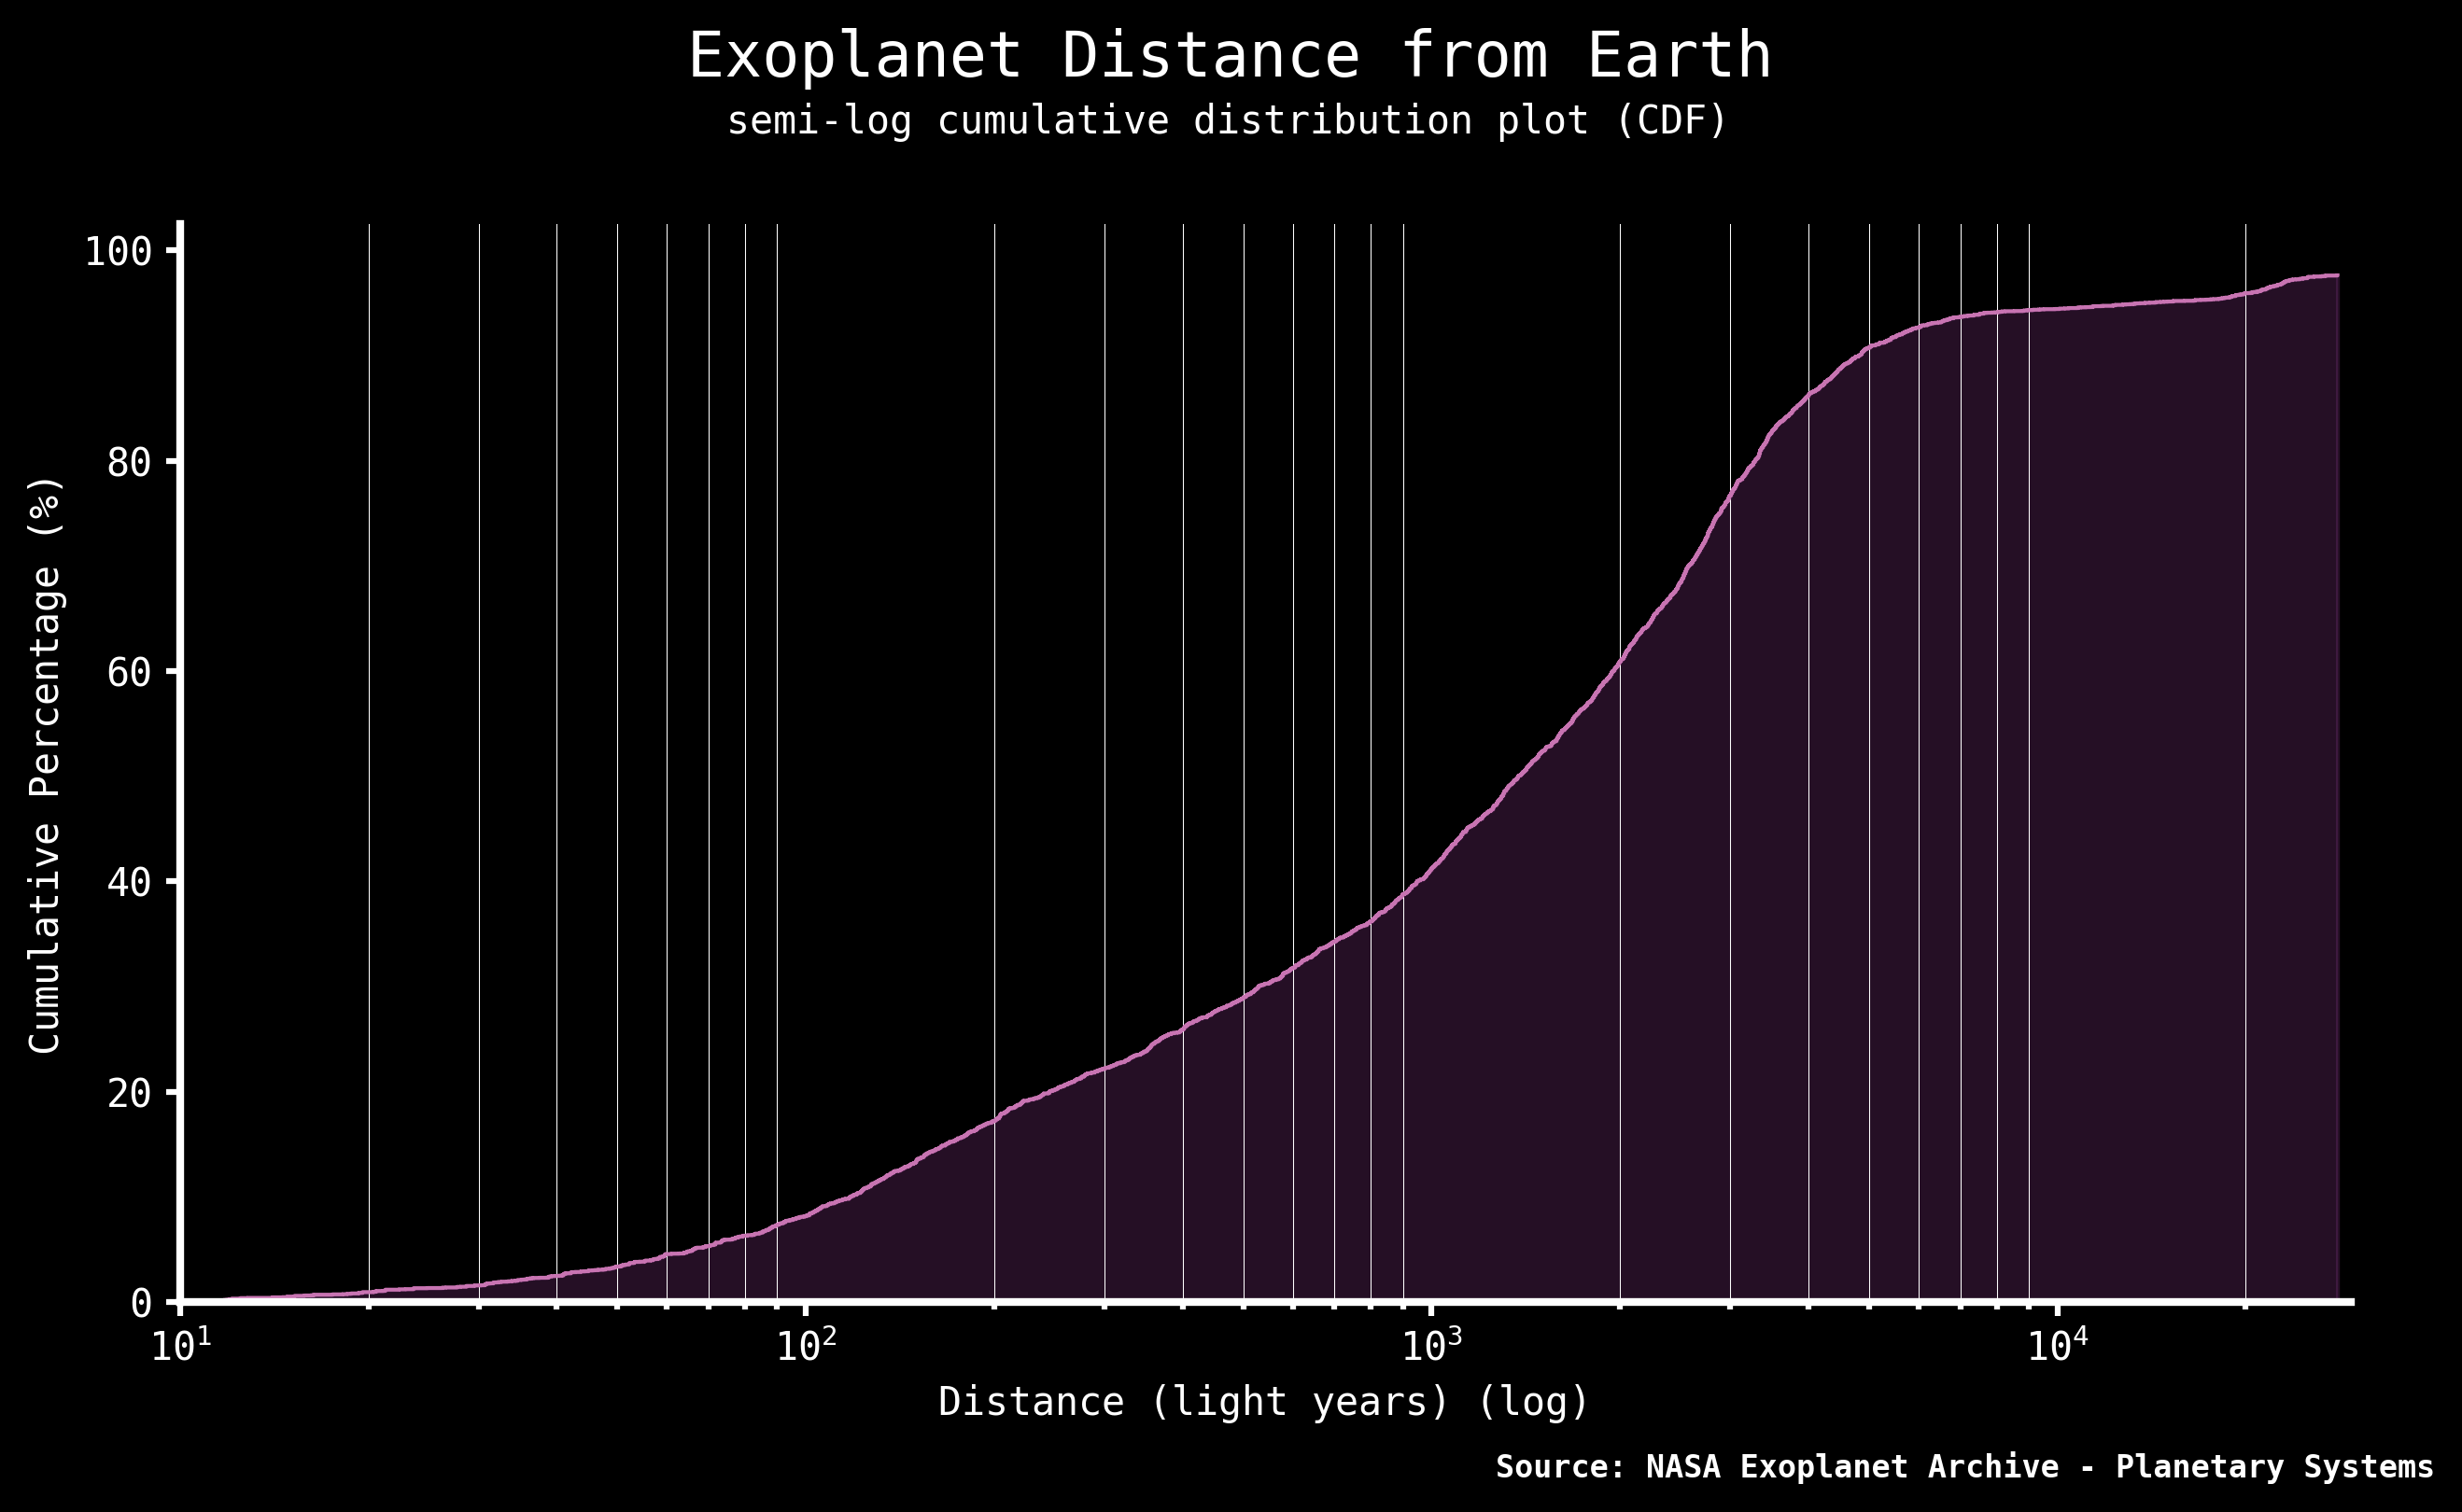

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Figure
fig.dpi = 300
fig.suptitle('Exoplanet Distance from Earth', fontsize=16, y=1.02)
fig.text(0.32, 0.945,"semi-log cumulative distribution plot (CDF)", fontsize=10)

# Computation of cumulative plot
sorted_distances = np.sort(exoplanets['Distance [pc]'] * 3.26)
cumulative_counts = np.arange(1, len(sorted_distances) + 1)
total_exoplanets = len(sorted_distances)
cumulative_percentage = (cumulative_counts / total_exoplanets) * 100
ax.step(sorted_distances, cumulative_percentage, where='post', color=color_palette[3], linestyle='-', linewidth=1)
ax.fill_between(sorted_distances, cumulative_percentage, step='post', color=color_palette[2], alpha=0.3)

fig.text(0.93, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='right', va='bottom',fontsize=8, fontweight='bold')

# Axis
ax.set_xlabel('Distance (light years) (log)', fontsize=10)
ax.set_xlim(left=10)
ax.set_xscale('log')
ax.set_ylabel('Cumulative Percentage (%)', fontsize=10)
ax.set_ylim(bottom=0)
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, color='w')

# Spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-4.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-4.png")
else:
  plt.show()

#### **Graph F - Exoplanet mass vs. radius (semi-log scatterplot)**

Simple scatterplot comparing radius and mass. We notice that actually the semi-log/lin-log plot comparing mass and radius generates a linear like. General positive correlation.

There is a higher density of planets with radii between 1 and 10 Earth radii and masses between 1 and 100 Earth masses.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

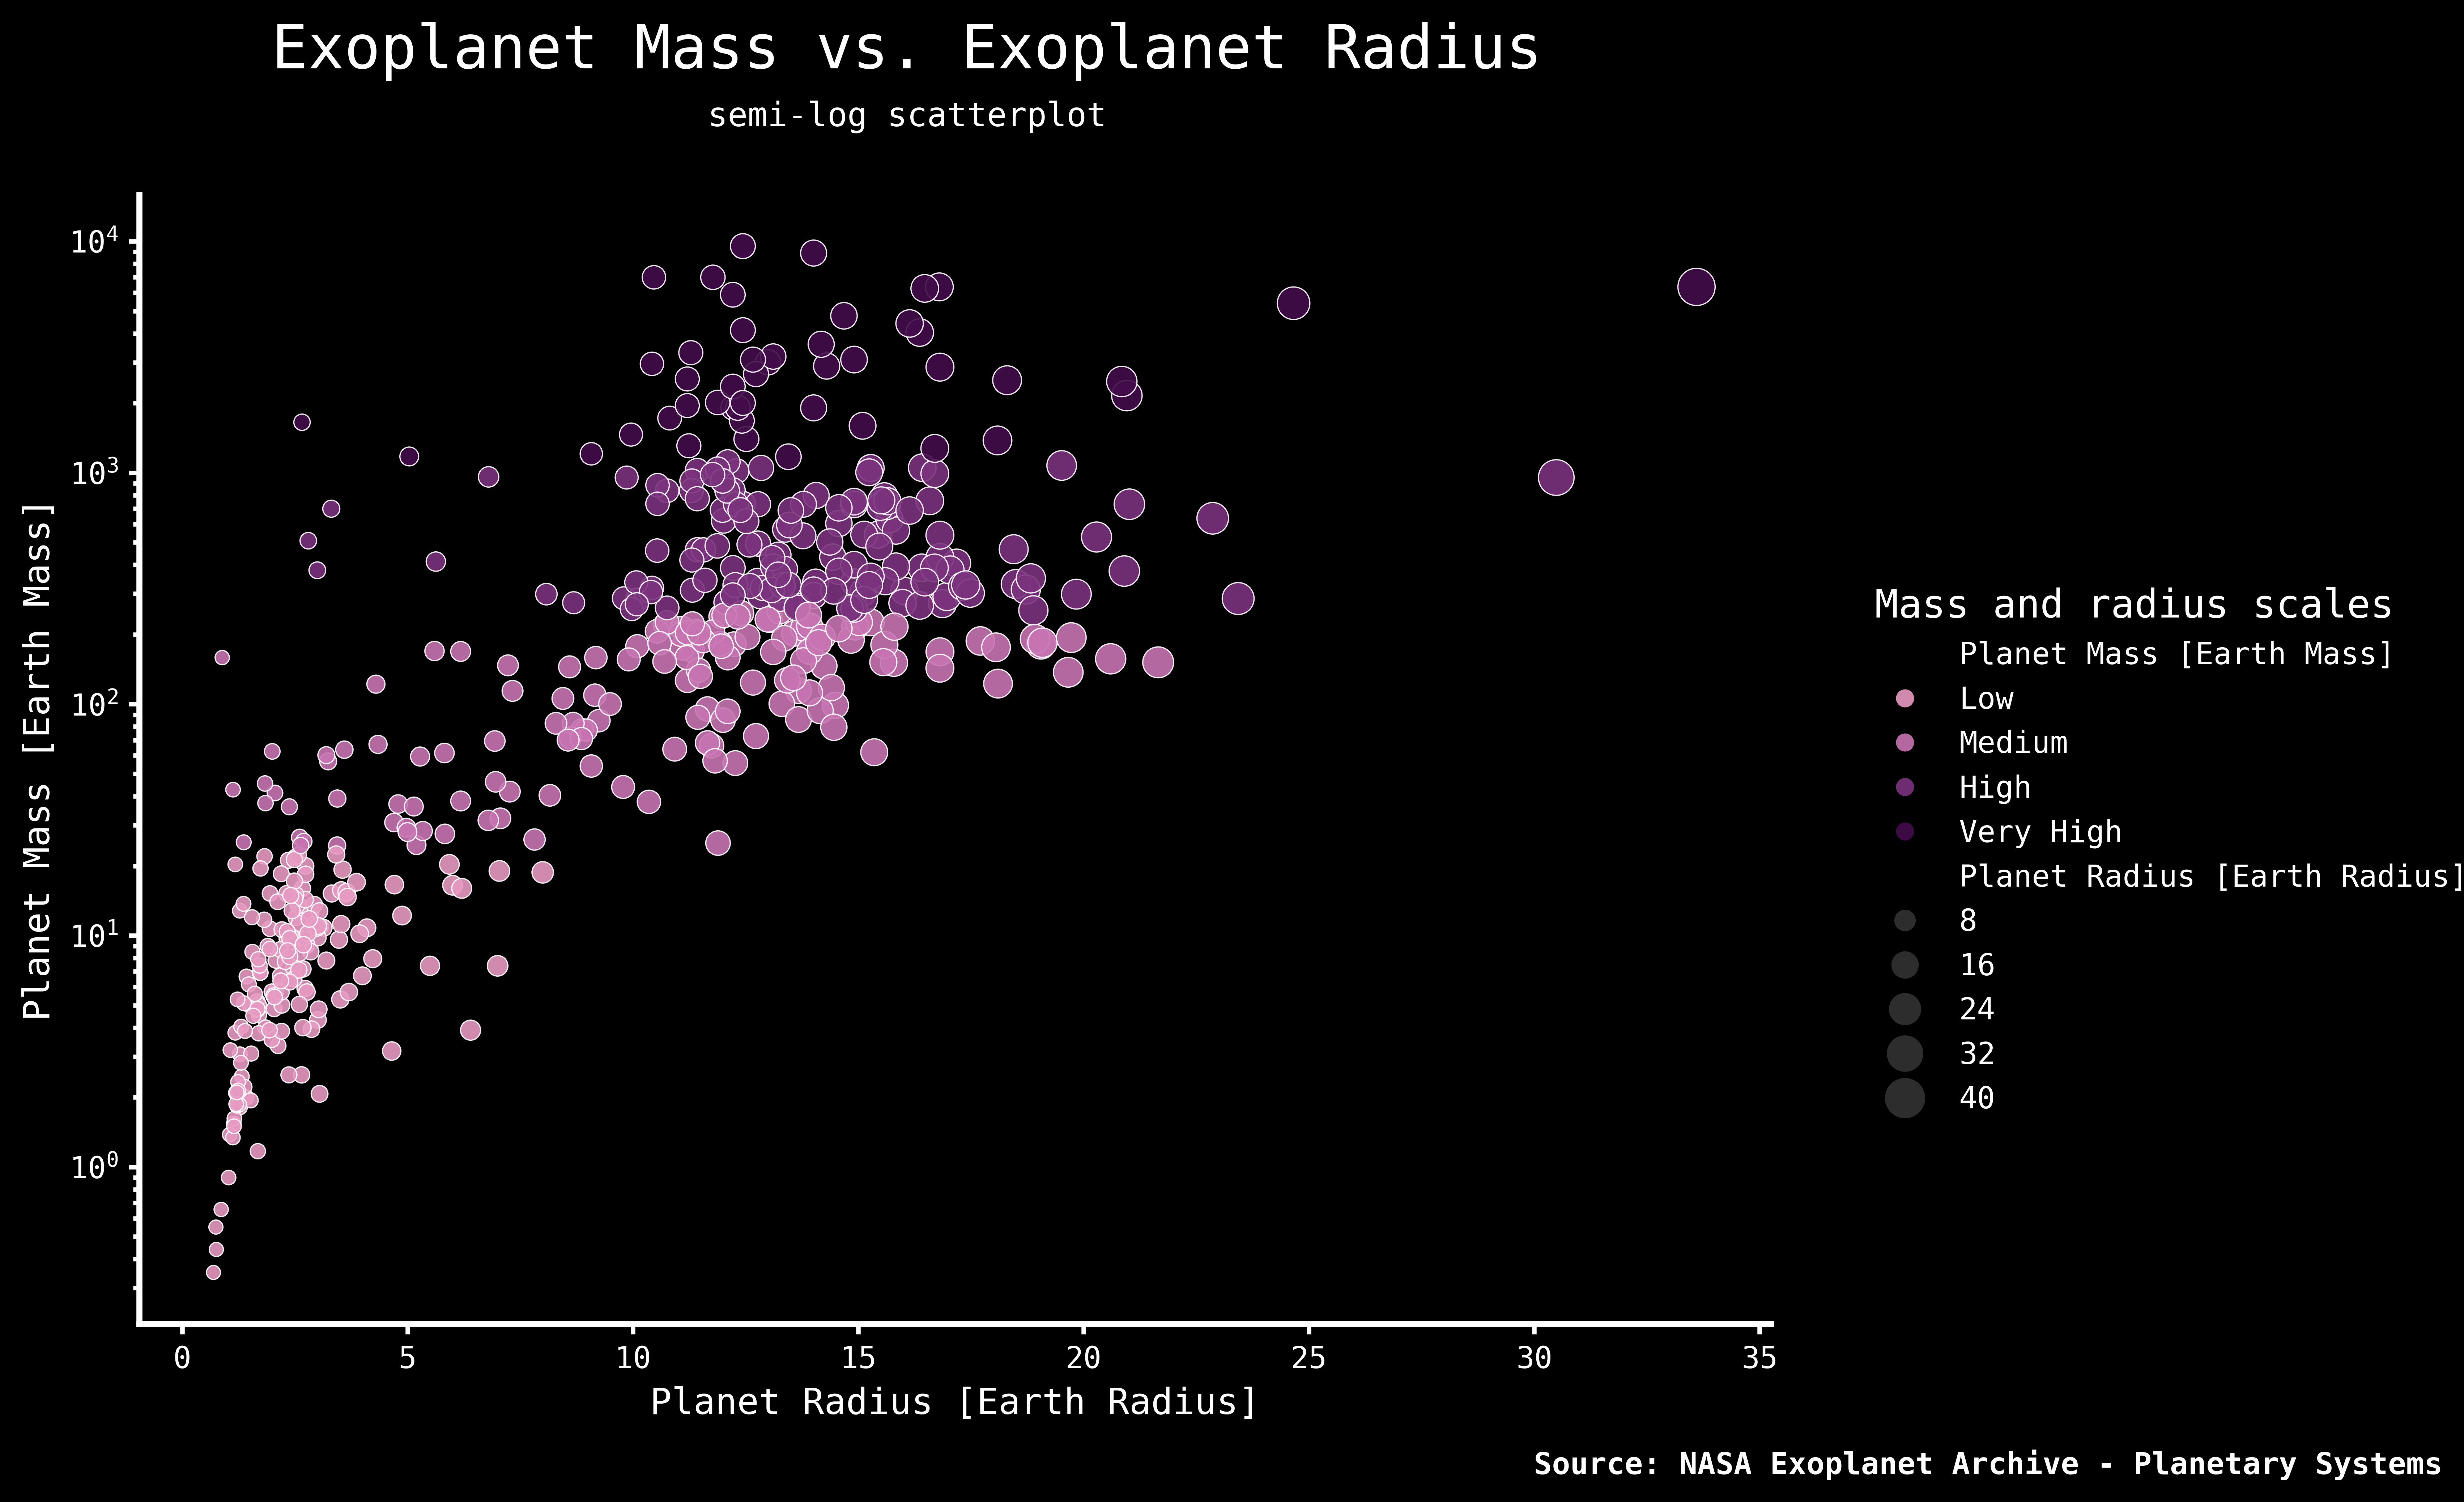

In [ ]:
exoplanets_radius = exoplanets[exoplanets['Planet Radius [Earth Radius]'] != exoplanets['Planet Radius [Earth Radius]'].max()]
mass_bins = pd.qcut(exoplanets_radius['Planet Mass [Earth Mass]'], q=4, labels=["Low", "Medium", "High", "Very High"])

# Scatter
scatter = sns.relplot(
            data=exoplanets_radius,
            x="Planet Radius [Earth Radius]",
            y="Planet Mass [Earth Mass]",
            hue=mass_bins,
            size="Planet Radius [Earth Radius]",
            palette=["#e79ac2", "#c874b2", "#7b337d", "#430d4b"],
            sizes=(20, 200),
            kind='scatter',
            legend="brief",
            height=6,
            aspect=1,
            alpha=0.9
        )

# Figure
scatter.fig.tight_layout()
scatter.fig.subplots_adjust(right=.95)
scatter.fig.suptitle('Exoplanet Mass vs. Exoplanet Radius', fontsize=20, y=1.1)
scatter.fig.text(0.5, 1.02,"semi-log scatterplot", ha="center", fontsize=11)

scatter.fig.text(1.3, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='right', va='bottom',fontsize=10, fontweight='bold')

# Axes
for ax in scatter.axes.flat:
    ax.set_yscale('log')
    ax.grid(False)
scatter.set_axis_labels('Planet Radius [Earth Radius]', 'Planet Mass [Earth Mass]')


# Legend
scatter._legend.set_title("Mass and radius scales", prop={'size': 13})
scatter._legend._legend_box.align = "left"
scatter._legend.set_bbox_to_anchor((1.3, 0.5))

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-5.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-5.png")
else:
  plt.show()

In [ ]:
centroids_original_scale

array([[3.10924734e+00, 1.15378052e+03],
       [1.38314895e+01, 8.42863692e+02],
       [5.75488810e+00, 6.13581540e+03],
       [3.69039433e+00, 9.11156827e+01]])

#### **Graph G - Exoplanet mass vs. radius and clusters (semi-log scatterplot)**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

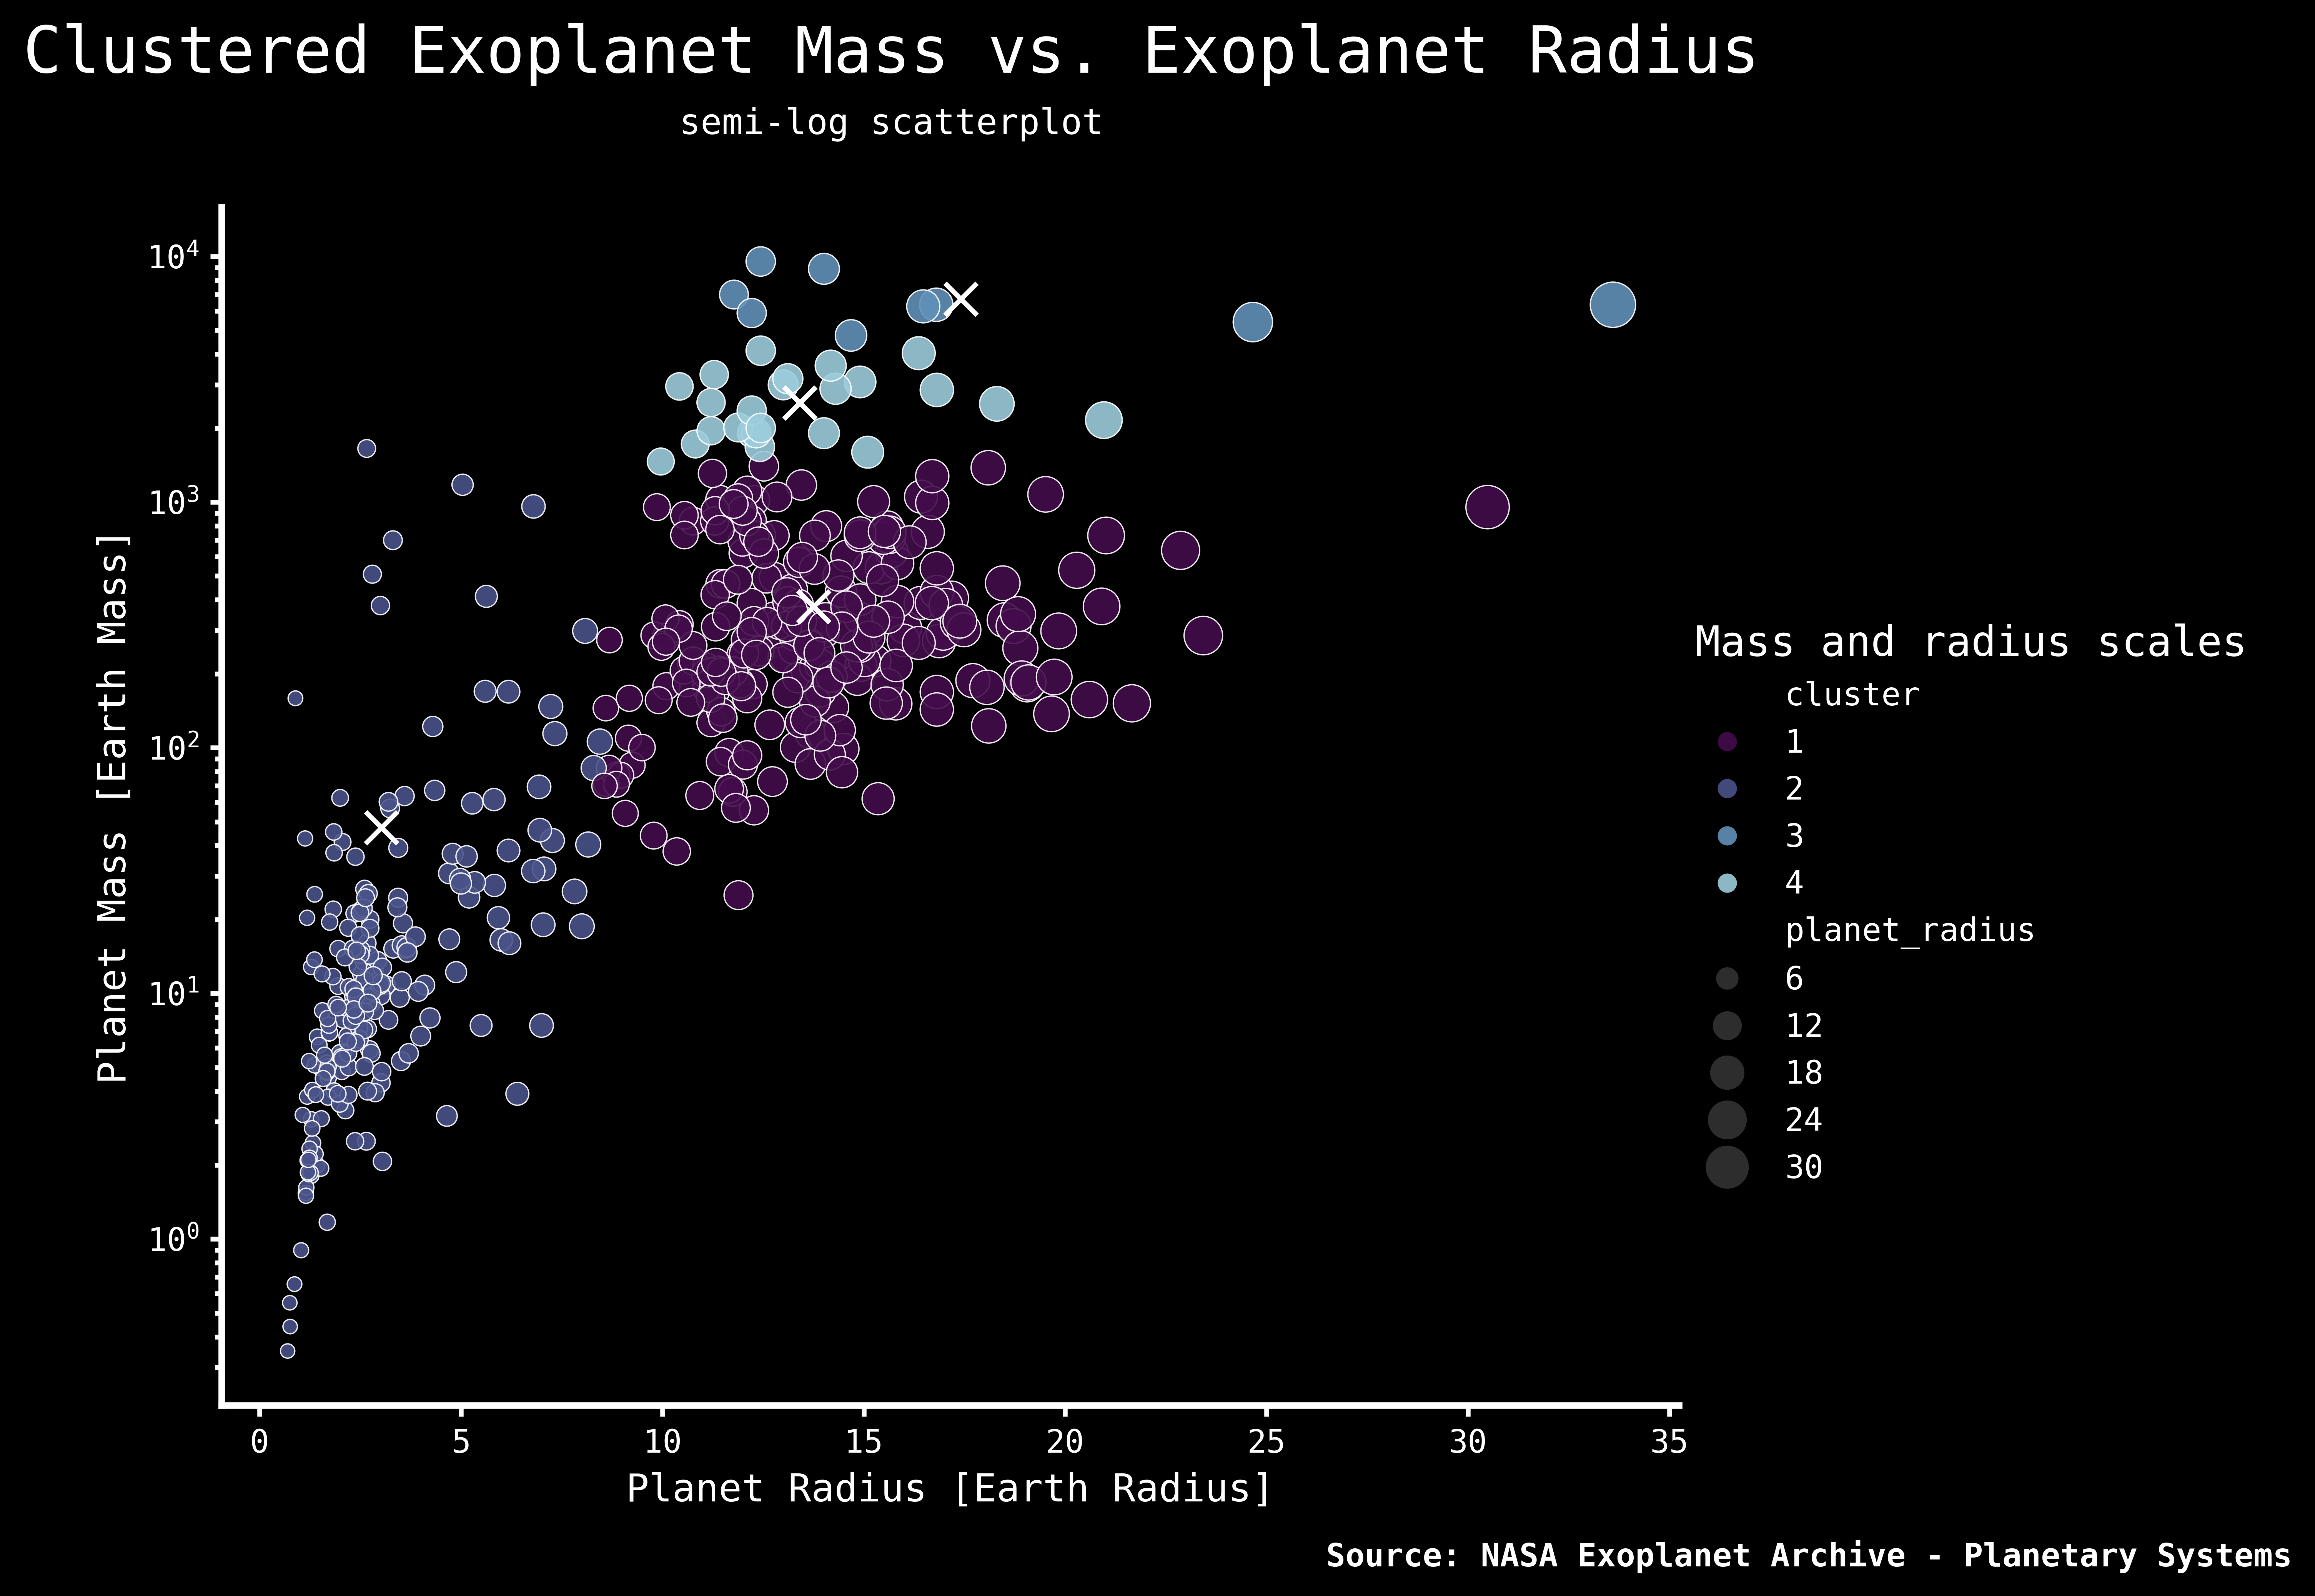

In [ ]:
# Scatter
scatter = sns.relplot(
            data=exoplanets_clustered,
            x="planet_radius",
            y="planet_mass",
            hue='cluster',
            size="planet_radius",
            palette= kmeans_palette,
            sizes=(20, 200),
            kind='scatter',
            legend="brief",
            height=6,
            aspect=1,
            alpha=0.9
        )

plt.scatter(
    centroids_original_scale[:, 0],
    centroids_original_scale[:, 1],
    c='white', marker='x', s=100, label='Centroids'
)

# Figure
scatter.fig.tight_layout()
scatter.fig.subplots_adjust(right=.95)
scatter.fig.suptitle('Clustered Exoplanet Mass vs. Exoplanet Radius', fontsize=20, y=1.1)
scatter.fig.text(0.5, 1.02,"semi-log scatterplot", ha="center", fontsize=11)
scatter.fig.text(1.3, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='right', va='bottom',fontsize=10, fontweight='bold')

# Axes
for ax in scatter.axes.flat:
    ax.set_yscale('log')
    ax.grid(False)
scatter.set_axis_labels('Planet Radius [Earth Radius]', 'Planet Mass [Earth Mass]')


# Legend
scatter._legend.set_title("Mass and radius scales", prop={'size': 13})
scatter._legend._legend_box.align = "left"
scatter._legend.set_bbox_to_anchor((1.30, 0.5))

# Saving or plotting
if save == True:
  plt.savefig("2024-05-24-exoplanets-6.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-6.png")
else:
  plt.show()

#### **Graph H - 3D projection - distance, mass, radius**

<ipython-input-467-d15c4ef72e6c>:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

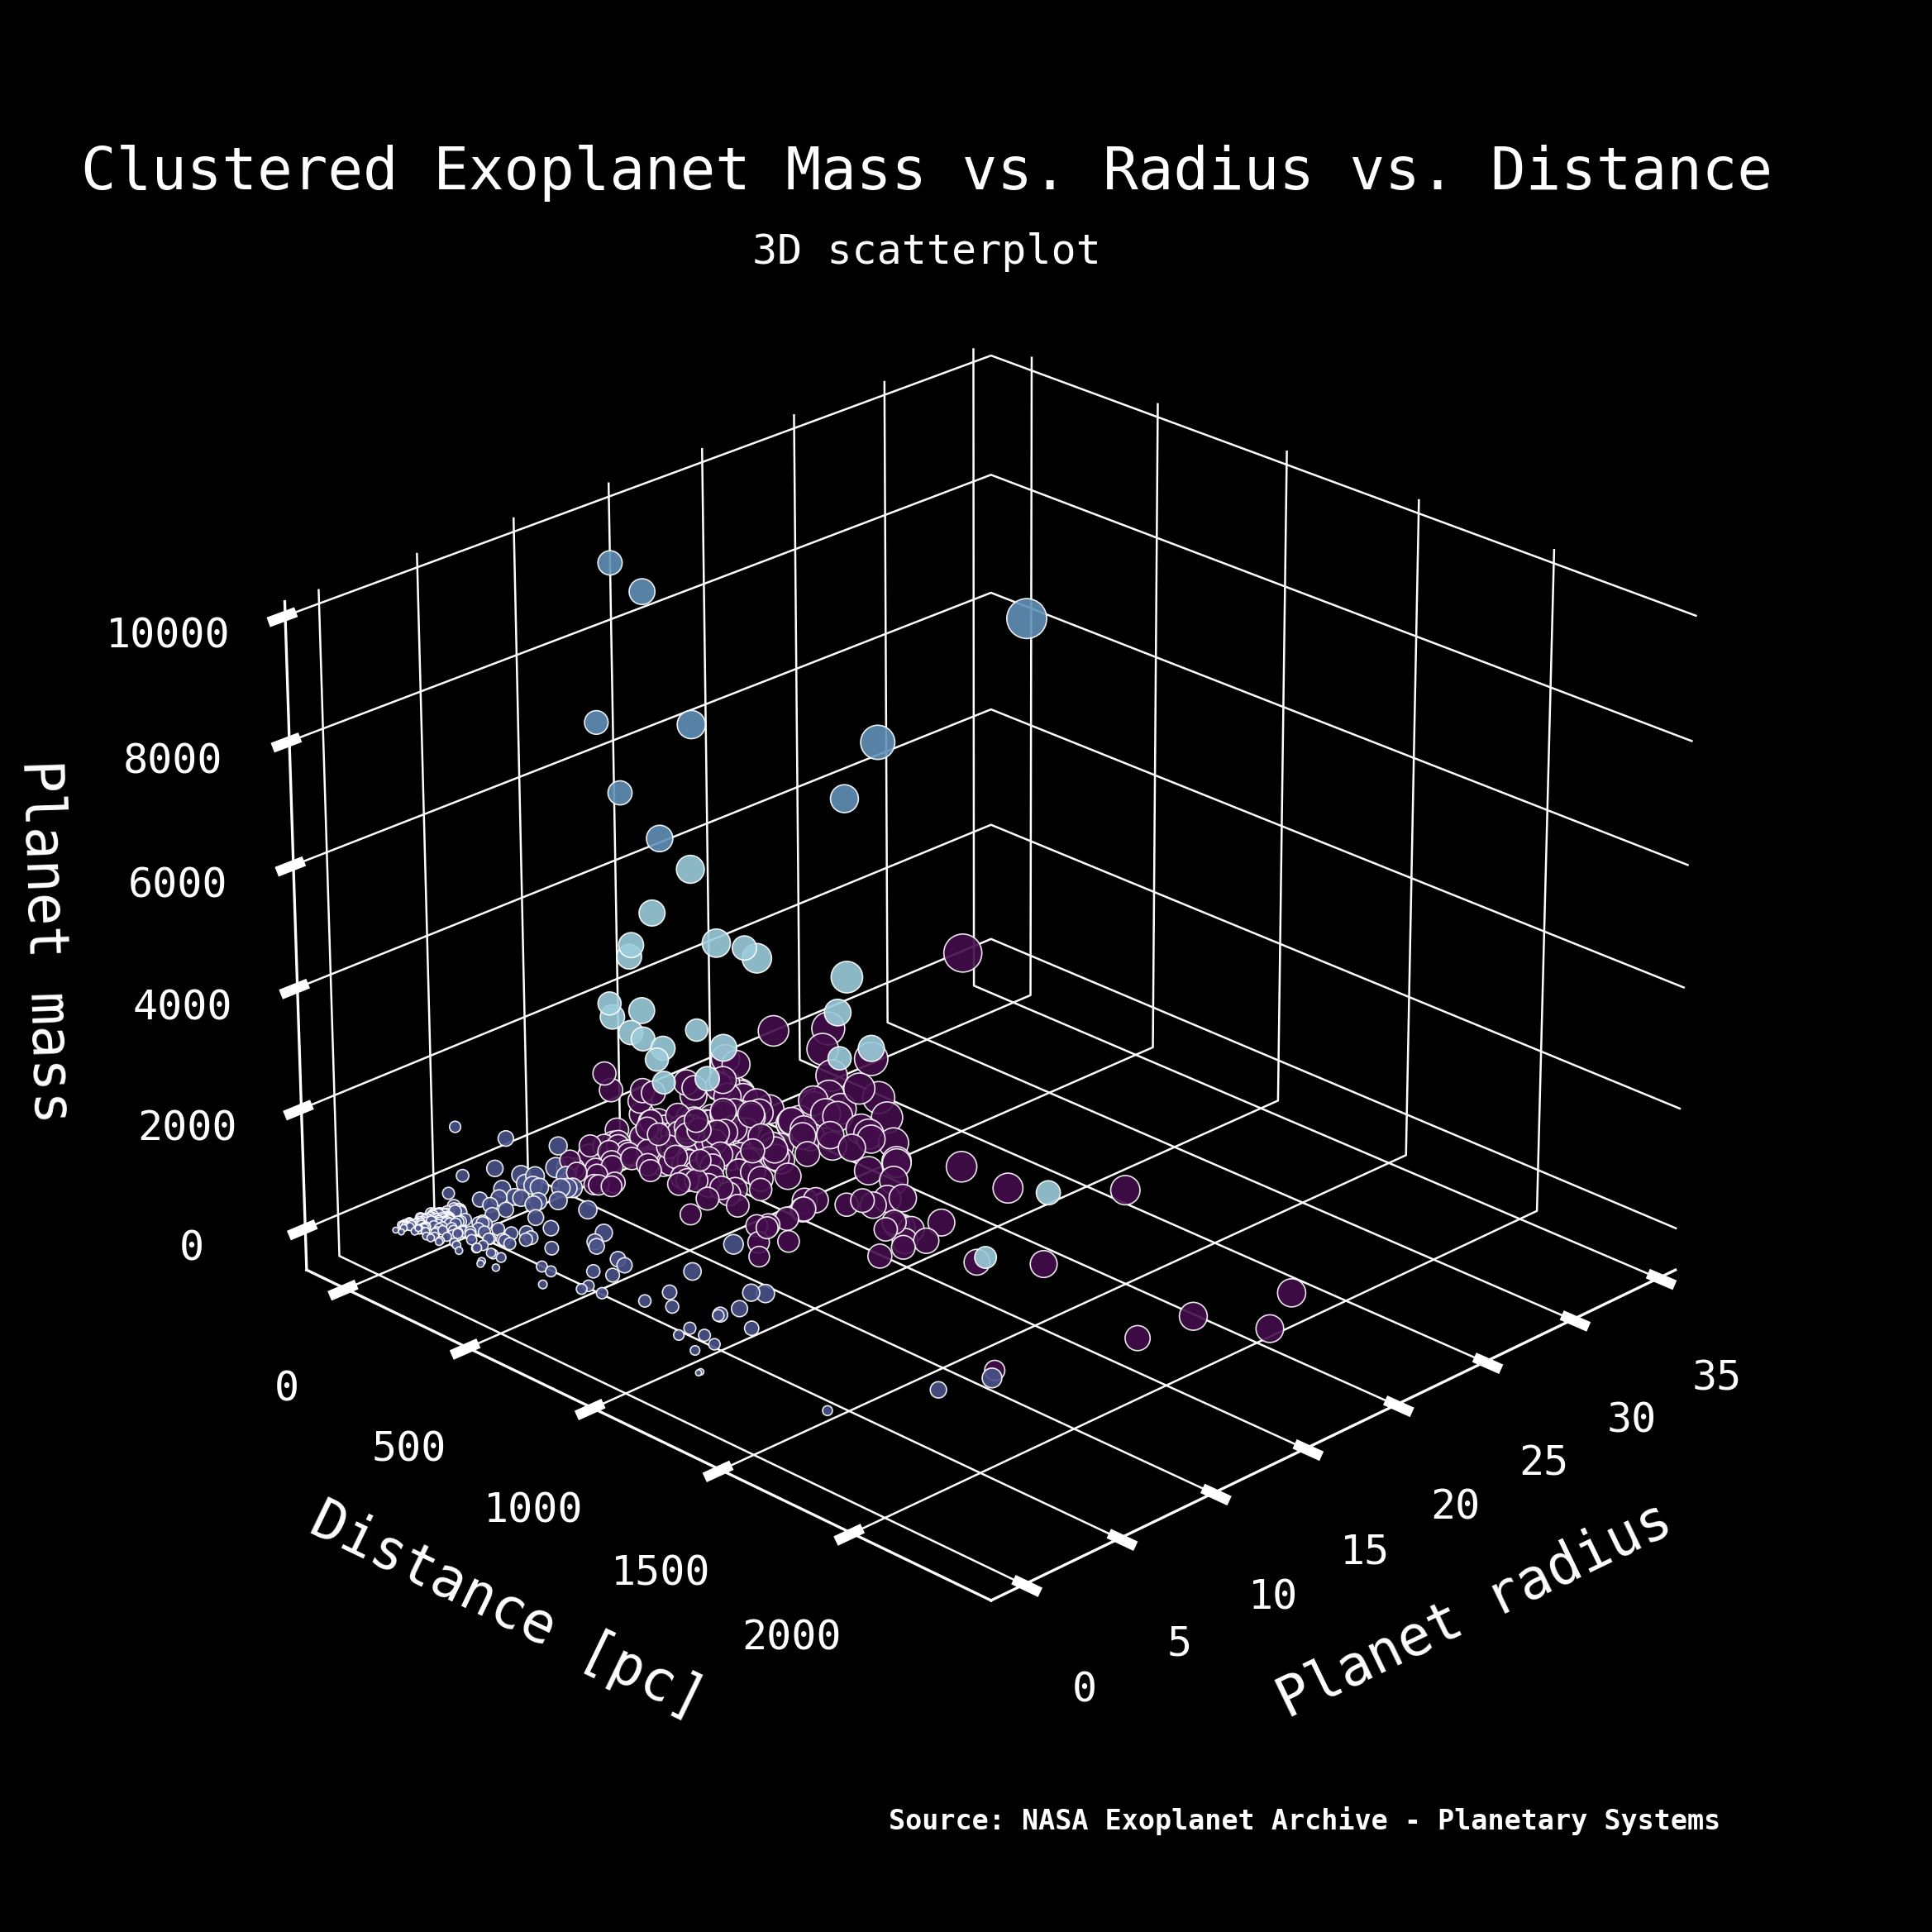

In [ ]:
fig = plt.figure()
fig.suptitle('Clustered Exoplanet Mass vs. Radius vs. Distance', fontsize=8.5, x=0.5,y=0.84)
fig.text(0.5, 0.79,"3D scatterplot", ha="center", fontsize=6)
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata = exoplanets_clustered['planet_radius']
ydata = exoplanets_clustered['distance_pc']
zdata = exoplanets_clustered['planet_mass']
hue = exoplanets_clustered['cluster']

ax.xaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.3)
ax.yaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.3)
ax.zaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.3)

ax.set_xlabel('Planet radius', fontsize = 8)
ax.set_ylabel('Distance [pc]', fontsize = 8)
ax.set_zlabel('Planet mass', fontsize = 8)

fig.text(0.75, 0.13, "Source: NASA Exoplanet Archive - Planetary Systems", ha='right', va='bottom',fontsize=4, fontweight='bold')

# Tick labels
ax.tick_params(axis='x', which='both', direction='in', length=6, width=0, colors='w', labelsize=6)
ax.tick_params(axis='y', which='both', direction='in', length=6, width=0.2, colors='w', labelsize=6)
ax.tick_params(axis='z', which='both', direction='in', length=6, width=0.2, colors='w', labelsize=6)

ax.xaxis.set_pane_color((0,0,0,0))  # White color with full opacity
ax.yaxis.set_pane_color((0,0,0,0))  # White color with full opacity
ax.zaxis.set_pane_color((0,0,0,0))  #

ax.view_init(elev=25, azim=45)
ax.dist = 12
#ax.set_xscale('log')
#ax.set_yscale('log')
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Axis line width
ax.xaxis.line.set_lw(0.4)
ax.yaxis.line.set_lw(0.4)
ax.zaxis.line.set_lw(0.4)

ax.invert_xaxis()

colors = kmeans_palette
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

#plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)

ax.scatter3D(xdata, ydata, zdata, c=hue, cmap=custom_cmap, s=xdata,alpha = 0.9, edgecolor="white", linewidths=0.2)


if save == True:
  plt.savefig("2024-05-24-exoplanets-7.png", bbox_inches = 'tight')
  files.download("2024-05-24-exoplanets-7.png")
else:
  plt.show()

We next track exoplanet distance from Earth. Unsurprisingly, the number of known exoplanets taper off with distance; limitations in measurement. Plotting a CDF of exolanet distance from Earth. Notice that close to 90% of known exoplanets are within the ten thousand light year range.